## Plot a CMD of objects near KKR 25:

KKR 25 on NED: https://ned.ipac.caltech.edu/byname?objname=KKR%2025&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1

# Exploring source measurements in a dwarf galaxy
<br>Owner(s): **Jeff Carlin** ([@jeffcarlin](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@jeffcarlin)), **Second Owner** ([@username2](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@username2))
<br>Last Verified to Run: **2020-07-24**
<br>Verified Stack Release: **20.0**

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Do this thing;
2. Do this other thing;
3. Understand this concept;
4. Produce your own etc etc.

### Logistics
This notebook is intended to be runnable on `lsst-lspdev.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Set-up

The next few cells give you some options for your "Set-up" section - you may not need them all.

We'll need the `stackclub` package to be installed. If you are not developing this package, you can install it using `pip`, like this:
```
pip install git+git://github.com/LSSTScienceCollaborations/StackClub.git#egg=stackclub
```
If you are developing the `stackclub` package (eg by adding modules to it to support the Stack Club tutorial that you are writing, you'll need to make a local, editable installation. In the top level folder of the `StackClub` repo, do:

In [1]:
! cd ~/stackclub/StackClub/ && python setup.py -q develop --user && cd -

/home/jcarlin/stackclub/StackClub/Measurement


When editing the `stackclub` package files, we want the latest version to be imported when we re-run the import command. To enable this, we need the %autoreload magic command.

In [2]:
%load_ext autoreload
%autoreload 2

You can find the Stack version that this notebook is running by using eups list -s on the terminal command line:

In [3]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-jcarlin-w-2020-29
lsst_distrib          20.0.0-1-g0037e03+7 	current w_2020_29 setup


For this tutorial we'll need the following modules:

In [34]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import IFrame, display, Markdown
from astropy.table import hstack, vstack
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from astropy.visualization import ZScaleInterval

In [33]:
import lsst.daf.persistence as dafPersist
import lsst.daf.base as dafBase

import lsst.afw.math as afwMath
import lsst.geom as geom

import lsst.afw.detection as afwDetect
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
import lsst.afw.coord as afwCoord

import lsst.afw.display as afwDisplay

import lsst.pipe.base as pipeBase

In [35]:
# Set up some plotting defaults:

params = {
   'axes.labelsize': 28,
   'font.size': 24,
   'legend.fontsize': 14,
#   'xtick.labelsize': 16,
   'xtick.major.width': 3,
   'xtick.minor.width': 2,
   'xtick.major.size': 12,
   'xtick.minor.size': 6,
   'xtick.direction': 'in',
   'xtick.top': True,
   'lines.linewidth':3,
   'axes.linewidth':3,
   'axes.labelweight':3,
   'axes.titleweight':3,
   'ytick.major.width':3,
   'ytick.minor.width':2,
   'ytick.major.size': 12,
   'ytick.minor.size': 6,
   'ytick.direction': 'in',
   'ytick.right': True,
#   'ytick.labelsize': 20,
#   'text.usetex': True,
#   'text.latex.preamble': r'\boldmath',
   'figure.figsize': [9, 8]
   }

plt.rcParams.update(params)

We are going to look at a known dwarf galaxy that is present in the HSC-SSP data release, but for which (as you'll see), the photometry is poor. This galaxy is called "KKR 25" -- here is more information about KKR 25 on NED: https://ned.ipac.caltech.edu/byname?objname=KKR%2025&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1

To help with finding the correct tract, the tract IDs of HSC data can be found at: https://hsc-release.mtk.nao.ac.jp/doc/index.php/database/

The following data discovery section follows this demo notebook: https://github.com/lsst-sqre/notebook-demo/blob/u/jcarlin/DM-15123/hsc_cosmos_comparison.ipynb

### Find and read the data

We will point to the shared repository containing processed HSC-SSP data. 

In [7]:
depth = 'DEEP' #'WIDE' -- which survey depth (DEEP, WIDE, ULTRA-DEEP) do you want?
butler = dafPersist.Butler('/datasets/hsc/repo/rerun/DM-13666/%s/'%(depth))

With the Gen2 Butler, the easiest way to know what tracts and patches are present is to parse the filenames. This will be easier with the Gen3 Butler.

In [8]:
infiles = glob.glob('/datasets/hsc/repo/rerun/DM-13666/%s/deepCoadd-results/HSC-I/*/*/calexp-*.fits'%(depth))
# How many tract/patch files are in this repo?
print(len(infiles))

1303


In order to find which tracts/patches our target is in, we first loop over all the files in the repository and extract their central RA, Dec coordinates into a pandas dataframe.

This involves reading the "skyMap" objects from the butler repository, and using the WCS and bounding box information to extract the coordinates for each patch.

In [9]:
def getPatchCenter(skymap, tract, patch):
    # Find the center of the patch BBox in pixel coordinates and convert with tract WCS
    patch = list(map(int, patch.split(',')))
    wcs = skymap.generateTract(tract).getWcs()
    bbox = skymap.generateTract(tract).getPatchInfo(patch).getInnerBBox()
    sky = wcs.pixelToSky(np.mean((bbox.getBeginX(), bbox.getEndX())), 
                         np.mean((bbox.getBeginY(), bbox.getEndY())))
    return sky[0].asDegrees(), sky[1].asDegrees()

tract_array = []
patch_array = []

# Each line of "infiles" looks like this (infile[0]):
# '/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-I/17130/8,8/calexp-HSC-I-17130-8,8.fits'

# Split on the '/', then parse the resulting array. Here's the result of infiles[0].split('/'):
#['',
# 'datasets',
# 'hsc',
# 'repo',
# 'rerun',
# 'DM-13666',
# 'DEEP',
# 'deepCoadd-results',
# 'HSC-I',
# '17130',
# '8,8',
# 'calexp-HSC-I-17130-8,8.fits']

# So the tract number is third from the end, and patch is second from the end.

for ii in range(0, len(infiles)):
    parts = infiles[ii].split('/')
    tract_array.append(int(parts[-3]))
    patch_array.append(parts[-2])

print('Found %i patches'%(len(patch_array)))
    
skymap = butler.get('deepCoadd_skyMap')
    
ra_center_array = np.tile(0., len(patch_array))
dec_center_array = np.tile(0., len(patch_array))
for ii, (tract, patch) in enumerate(zip(tract_array, patch_array)):
    ra_center_array[ii], dec_center_array[ii] = getPatchCenter(skymap, tract, patch)
    
# Assemble in pandas data frame    
data = {'tract': tract_array,
        'patch': patch_array, 
        'ra_center': ra_center_array, 
        'dec_center': dec_center_array}
df_tract_patch = pd.DataFrame(data=data)

Found 1303 patches


Where are these data on the sky? Let's plot a map.

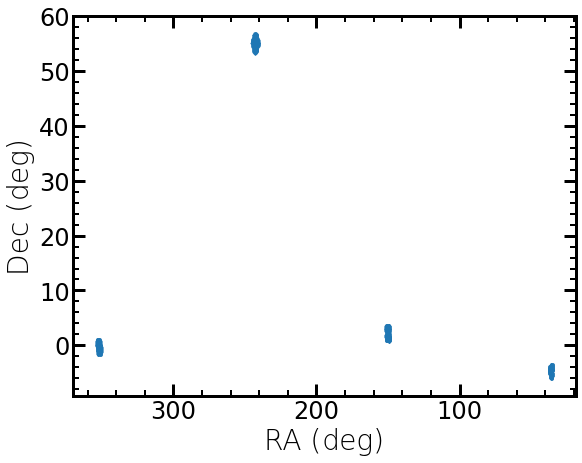

In [19]:
# Plot RA, Dec of patch centers:

fig=plt.figure()
plt.scatter(df_tract_patch['ra_center'], df_tract_patch['dec_center'], marker='.', s=5)
# From looking it up on NED, KKR 25 is in the "ELAIS-N1" field.
# Uncomment the xlim, ylim below to zoom in on that region.
#plt.xlim(238., 246.)
#plt.ylim(52., 58.)
plt.gca().invert_xaxis() # flip the x-axis so the plot is "sky-right"
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.minorticks_on()
plt.show()

### Locate KKR 25 within the patches with HSC data

To figure out which patch(es) KKR 25 is located within, we will use Astropy "SkyCoord" objects. It is then straightforward to calculate the separation of KKR 25 from the centers of all the patches we extracted above. Then we'll find the closest patches, which (hopefully) contain KKR 25.

In [31]:
# Create "SkyCoord" objects for the central coordinate of KKR25 (or CetusIII, VirgoI?), and the patch centers of HSC:
kkr25_pos = SkyCoord(243.448333*u.degree, 54.37111*u.degree, frame='icrs') # KKR25
#cosmos_patch_cen = SkyCoord(180.04*u.degree, 0.68*u.degree, frame='icrs') # VirgoI
hsc_patch_cen = SkyCoord(df_tract_patch['ra_center'].values*u.degree, df_tract_patch['dec_center'].values*u.degree, frame='icrs')

# Calculate the separation (in degrees) of each HSC patch from KKR25:
sep_patches = hsc_patch_cen.separation(kkr25_pos)

# Pick patches within 'size_select' deg of KKR25:
size_select = 0.25 # in degrees
selection_patch = (sep_patches.degree < size_select) 
print('Number of patches selected: ',np.sum(selection_patch))

# Add the separation (in arcminutes) to the dataframe:
df_tract_patch['sep_from_kkr25'] = sep_patches.arcmin

# Extract just the selected (nearby) patches:
df_selected = df_tract_patch[selection_patch]

Number of patches selected:  8


In [32]:
# Print some info about the selected patches:
df_selected

tract patch   ra_center  dec_center  sep_from_kkr25
3    17130   0,4  243.779176   54.290800       12.537841
6    17130   1,5  243.463800   54.480400        6.579589
15   17130   0,5  243.784999   54.477419       13.371343
62   17130   2,4  243.139628   54.295875       11.705172
73   17130   1,4  243.459432   54.293760        4.657199
76   17130   2,5  243.142540   54.482530       12.594279
733  17131   8,4  243.720664   54.290798       10.677045
742  17131   8,5  243.714840   54.477417       11.279527

From this table, it looks like KKR 25 is nearest the center of (tract, patch)=(17130, '1,4'). 

For context about the size of patches, HSC pixels are ~0.168" per pixel, and a patch is 4k x 4k. Thus each patch is about (4k * 0.168") = 672 arcsec = 11.2 arcmin = 0.1867 deg. on a side.

### Confirm that KKR 25 is visible in the images of these patches

To do this, we will create "data references" -- for coadd images, these are based on the filter, tract, and patch. These three dimensions specify a unique data ID, and are fed to the butler as a dictionary.

In [55]:
dataref14 = {'tract':17130, 'patch':'1,4', 'filter':'HSC-G'}

# Note that we can extract the information directly from the dataframe we made above rather
#   than explicity typing the values, like so:
#dataref14 = {'tract':df_selected.iloc[4]['tract'],'patch':df_selected.iloc[4]['patch'],
#             'filter':'HSC-G'}

If you want to know what types of data *may be* present in the butler repository, you can uncomment the following line for a list. BEWARE: it's a long list!

In [56]:
#butler.getDatasetTypes()

However, that only lists dataset types that are defined. It doesn't actually tell you if they exist *in this repository*. To find that out, you can use the "datasetExists" method. (For example, here we'll check whether the "forced_src" catalog exists for dataref14.)

In [57]:
butler.datasetExists('deepCoadd_forced_src', dataId=dataref14)

True

### Get the images and catalogs for the two patches of interest:

In particular, we'll use the forced photometry ("deepCoadd_forced_src") and the deep coadd images ("deepCoadd_calexp"). 

Notice that the *calexp* has a WCS and a "PhotoCalib" associated with it - we'll extract these for later use (if we want to convert XY pixel values to RA, Dec, or fluxes to magnitudes).

In [77]:
### Source catalog:
#my_src14 = butler.get('deepCoadd_forced_src', dataId=dataref14)
#
## Calibrated exposure:
#my_calexp14 = butler.get('deepCoadd_calexp', dataId=dataref14)
#
## Extract the WCS and the calib object for each patch:
#my_wcs14 = my_calexp14.getWcs()
#my_calib14 = my_calexp14.getPhotoCalib()

In [78]:
# Full patch image
image14 = butler.get('deepCoadd_calexp', immediate=True, dataId=dataref14)
# Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
xy0_14 = image14.getXY0() 

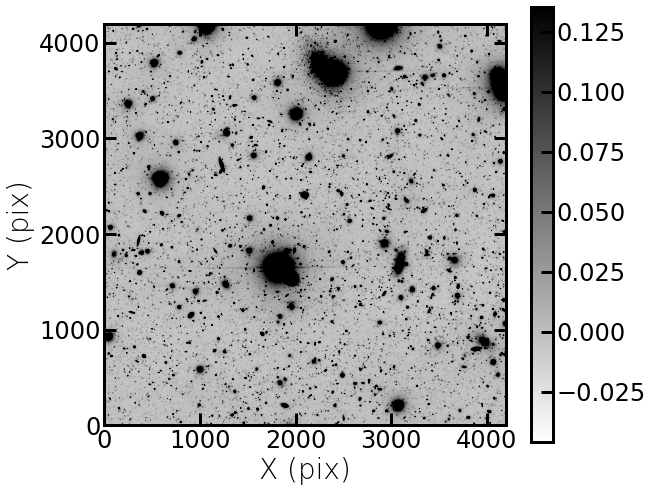

In [79]:
zscale = ZScaleInterval()

plt.rcParams.update({'figure.figsize' : (9, 8)})

vmin14, vmax14 = zscale.get_limits(image14.image.array)
# Get the dimensions of the image so we can set plot limits
imsize14 = image14.getDimensions()
plt.imshow(image14.image.array, vmin=vmin14, vmax=vmax14, cmap='binary')

# Set the plot range to the dimensions:
plt.xlim(0,imsize14[0])
plt.ylim(0,imsize14[1])
plt.colorbar()
plt.xlabel('X (pix)')
plt.ylabel('Y (pix)')

plt.show()

KKR 25 is the semi-resolved blob of stars at the top, partially obscured by a bright star.

### Create an image (from multiple patches) centered on KKR 25:
(borrowing heavily from `ip_diffim`)

Maybe instead of being limited by the patch boundaries, we would like an image that is centered on the dwarf. This will require putting together images from multiple patches

In [67]:
# A useful function we'll use in a little bit.
#   Calculate the number of pixels in a given N-arcmin area.
def arcmin2pix(narcmin):
    arcsecPerPix = 0.168  # HSC pixels are 0.168"/pixel
    arcminPerPix = arcsecPerPix / 60.0
    npix = narcmin/arcminPerPix
    return int(np.rint(npix))    

This function creates a cutout image centered on *raDec*, of size *size_arcmin*, with the center of the image in the patch denoted by *dataref*. It does the following:
1. Extract the skymap, calexp, and WCS.
2. Create an empty bounding box of the specified size, centered on the given position.
3. Taking the corners of the bounding box, use the function defined earlier to look up which patches overlap that bounding box.
4. Extract the subregions (using the "deepCoadd_calexp_sub" object) from the overlapping pathches, and insert them into the bounding box we created.
5. Return the cutout image as an ExposureF.

In [68]:
def cutoutImage(raDec, size_arcmin, dataref):
    '''
    Function to extract an image cutout.
    Inputs:
      raDec: an afwGeom.SpherePoint object with desired RA, Dec center 
      size_arcmin: desired image size (in arcminutes)
      filter: desired filter of extracted image (string)
    '''
# Start with a center position and make a bbox centered there, and expand it to include data from neighboring patches:
    skyMap =  butler.get("deepCoadd_skyMap", immediate=True, dataId=dataref)
    tmp_calexp = butler.get("deepCoadd_calexp", immediate=True, dataId=dataref)
    expWcs = tmp_calexp.getWcs()

    size_pixels = arcmin2pix(size_arcmin)
    print('npixels: ',size_pixels)
    cutoutSize = geom.ExtentI(size_pixels, size_pixels) # size of cutout in pixels
    print('cutoutSize: ',cutoutSize)
    print(expWcs.skyToPixel(raDec))
    xy = geom.Point2I(expWcs.skyToPixel(raDec)) # central XY coordinate of our star's RA, Dec position

#    print('xy: ',xy,' cutoutSize: ',cutoutSize)

# Create the bounding box:
    bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)
    bbox = geom.Box2D(bbox)

    tractInfo = skyMap.findTract(raDec)
    skyCorners = [expWcs.pixelToSky(pixPos) for pixPos in bbox.getCorners()]
    patchList = tractInfo.findPatchList(skyCorners)

# compute coadd bbox
    coaddWcs = tractInfo.getWcs()
    coaddBBox = geom.Box2D()
    for skyPos in skyCorners:
        coaddBBox.include(coaddWcs.skyToPixel(skyPos))
    coaddBBox = geom.Box2I(coaddBBox)

# assemble coadd exposure from subregions of patches
    coaddExposure = afwImage.ExposureF(coaddBBox, coaddWcs)
    coaddExposure.maskedImage.set(np.nan, afwImage.Mask.getPlaneBitMask("NO_DATA"), np.nan)
    nPatchesFound = 0
    coaddFilter = None
    for patchInfo in patchList:
        patchSubBBox = patchInfo.getOuterBBox()
        patchSubBBox.clip(coaddBBox)
        patchArgDict = dict(
                            datasetType="deepCoadd_calexp_sub",
                            bbox=patchSubBBox,
                            tract=tractInfo.getId(),
                            patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                            filter = dataref['filter'],
                            )
        print("Reading patch %s" % patchArgDict)
        coaddPatch = butler.get(**patchArgDict)
        nPatchesFound += 1
        coaddExposure.maskedImage.assign(coaddPatch.maskedImage, coaddPatch.getBBox())
        if coaddFilter is None:
            coaddFilter = coaddPatch.getFilter()

    if nPatchesFound == 0:
        raise RuntimeError("No patches found!")

    coaddExposure.setFilter(coaddFilter)
    return pipeBase.Struct(exposure=coaddExposure, sources=None)

Now define a similar function, but creating a catalog of the sources in the cutout region.

In [69]:
def cutoutCatalog(raDec, size_arcmin, dataref):
    '''
    Function to extract an catalog cutout.
    Inputs:
      raDec: an afwGeom.SpherePoint object with desired RA, Dec center 
      size_arcmin: desired image size (in arcminutes)
      filter: desired filter of extracted image (string)
    '''
# Start with a center position and make a bbox centered there, and expand it to include data from neighboring patches:
    skyMap =  butler.get("deepCoadd_skyMap", immediate=True, dataId=dataref)
    tmp_calexp = butler.get("deepCoadd_calexp", immediate=True, dataId=dataref)
    expWcs = tmp_calexp.getWcs()

    size_pixels = arcmin2pix(size_arcmin)
    cutoutSize = geom.ExtentI(size_pixels, size_pixels) # size of cutout in pixels
    xy = geom.Point2I(expWcs.skyToPixel(raDec)) # central XY coordinate of our star's RA, Dec position
    
# Create the bounding box:
    bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)
    bbox = geom.Box2D(bbox)

    tractInfo = skyMap.findTract(raDec)
    skyCorners = [expWcs.pixelToSky(pixPos) for pixPos in bbox.getCorners()]
    patchList = tractInfo.findPatchList(skyCorners)
    print('Npatches: ',len(patchList))

    nPatchesFound = 0
    for patchInfo in patchList:
        patchArgDict = dict(
                            datasetType="deepCoadd_forced_src",
                            tract=tractInfo.getId(),
                            patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                            filter = dataref['filter'],
                            flags=afwTable.SOURCE_IO_NO_FOOTPRINTS
                            )
        print("Reading patch %s" % patchArgDict)
        src = butler.get(**patchArgDict)
        nPatchesFound += 1

        patchArgDict_ref = dict(
                                datasetType="deepCoadd_ref",
                                tract=tractInfo.getId(),
                                patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                                filter = dataref['filter'],
                                flags=afwTable.SOURCE_IO_NO_FOOTPRINTS
                                )
        print("Reading ref cat for patch %s" % patchArgDict_ref)
        refcat = butler.get(**patchArgDict_ref)

        patchArgDict_calib = dict(
                                datasetType="deepCoadd_calexp_photoCalib",
                                tract=tractInfo.getId(),
                                patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                                filter = dataref['filter'],
                                flags=afwTable.SOURCE_IO_NO_FOOTPRINTS
                                )
        print("Reading calib for patch %s" % patchArgDict_calib)
        calib = butler.get(**patchArgDict_calib)
        psfmags = calib.instFluxToMagnitude(src, 'base_PsfFlux')
        modelmags = calib.instFluxToMagnitude(src, 'modelfit_CModel')
        
        # Create an empty Astropy Table, then insert the magnitudes into it.
        mags = Table()
        mags['psfmag'] = psfmags
        mags['modelmag'] = modelmags


        if nPatchesFound == 1:
            print('patch: 1')
            tmp_src = src
            tmp_ref = refcat
            tmp_mags = mags
            tmp_calib = calib
        else:
            print('patch: ',nPatchesFound)
            tmp_src.extend(src)
            tmp_ref.extend(refcat)
            tmp_mags = vstack([tmp_mags,mags])
            
        print('length of tmp_src, tmp_ref, tmp_mags: ',len(tmp_src),len(tmp_ref), len(tmp_mags))


    print('Making deep copies')
    cat_final = tmp_src.copy(deep = True)
    ref_final = tmp_ref.copy(deep = True)


    if nPatchesFound == 0:
        raise RuntimeError("No patches found!")

    return cat_final, ref_final, tmp_mags

In [70]:
size_arcmin = 3.0

# Create a SpherePoint object at the center of KKR 25:
raDec = geom.SpherePoint(kkr25_pos.ra.value, kkr25_pos.dec.value, geom.degrees)

# Extract the cutout image:
imgCutout = cutoutImage(raDec, size_arcmin, dataref14)

npixels:  1071
cutoutSize:  (1071, 1071)
(6161.1, 19656)
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5626, 19120), dimensions=Extent2I(1072, 980)), 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G'}
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5626, 19900), dimensions=Extent2I(1072, 292)), 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G'}


Notice from the outputs of the previous cell that two patches were needed to create the image. Now, how does it look? (Can we clearly see the dwarf galaxy in it?)

<Figure size 648x576 with 0 Axes>

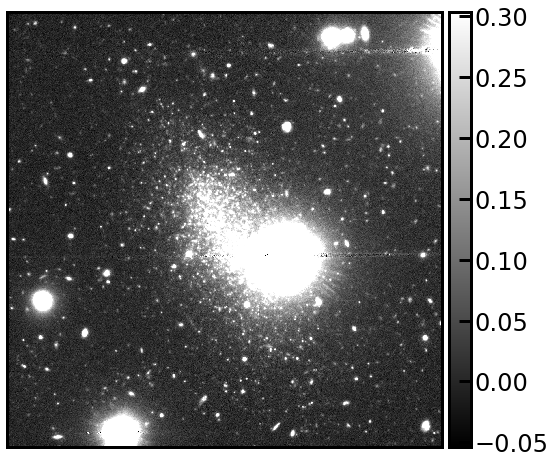

In [73]:
plt.rcParams.update({'figure.figsize' : (9, 8)})

# Use lsst.afw.display with the matplotlib backend to display the image
afwDisplay.setDefaultBackend('matplotlib') 
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('linear', 'zscale')
afw_display.mtv(imgCutout.exposure.image)
plt.xticks([])
plt.yticks([])
# plt.savefig('kkr25_image.png') # Uncomment if you want to save the image.
plt.show()

There's a beautiful, partially-resolved galaxy there. Unfortunately, there's a bright star right next to it. We'll have to see how that affects the measurements from the Stack.

What does the mask plane look like in this region?

<Figure size 648x576 with 0 Axes>

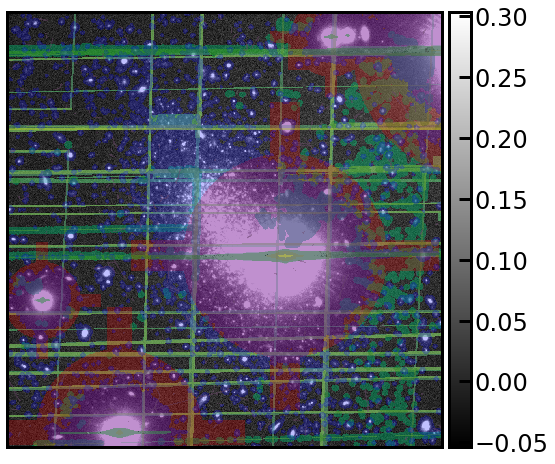

In [74]:
afwDisplay.setDefaultBackend('matplotlib') 
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('linear', 'zscale')
afw_display.mtv(imgCutout.exposure.maskedImage)
plt.xticks([])
plt.yticks([])
plt.show()

In [75]:
# The MaskedImage is overplotting the values of the mask plane. 
# Extract the mapping between mask color and mask bit directly from the mask object:

for maskName, maskBit in imgCutout.exposure.mask.getMaskPlaneDict().items():
    print('{}: {}'.format(afw_display.getMaskPlaneColor(maskName),maskName))

red: BAD
None: BRIGHT_OBJECT
None: CLIPPED
magenta: CR
None: CROSSTALK
blue: DETECTED
cyan: DETECTED_NEGATIVE
yellow: EDGE
None: INEXACT_PSF
green: INTRP
None: NOT_DEBLENDED
orange: NO_DATA
None: REJECTED
green: SAT
None: SENSOR_EDGE
yellow: SUSPECT
None: UNMASKEDNAN


OK, so this is telling us that the stars in KKR 25 (because they are blue in the mask) are flagged as DETECTED, but are mostly beneath the BAD mask from the bright star. 

Extract concatenated source catalogs in the same footprint using the function we defined above. (Note: this returns catalog data for the entire patches that are part of the requested footprint, and not just within the radius specified.) We'll grab three bands (gri).

The *cutoutCatalog* function returns the forced photometry ("deepCoadd_forced_src"), the reference catalog of combined information for all bandpasses ("deepCoadd_ref"), and the calibrated magnitudes (PSF and cmodel magnitudes).

*The following cell may take a few minutes to execute.*

In [76]:
dr14_i = dataref14.copy()
dr14_i['filter'] = 'HSC-I'
dr14_r = dataref14.copy()
dr14_r['filter'] = 'HSC-R'
dr14_g = dataref14.copy()
dr14_g['filter'] = 'HSC-G'
cat_g, refcat_g, mags_g = cutoutCatalog(raDec, size_arcmin, dr14_g)
cat_r, refcat_r, mags_r = cutoutCatalog(raDec, size_arcmin, dr14_r)
cat_i, refcat_i, mags_i = cutoutCatalog(raDec, size_arcmin, dr14_i)

Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading calib for patch {'datasetType': 'deepCoadd_calexp_photoCalib', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
patch: 1
length of tmp_src, tmp_ref, tmp_mags:  30285 30285 30285
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
Reading calib for patch {'datasetType': 'deepCoadd_calexp_photoCalib', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
patch:  2
length of tmp_src, tmp_ref, tmp_mags:  61007 61007 61007
Making deep copies
Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch

### Make some selections based on the data flags:

- detect_isPrimary (see https://pipelines.lsst.io/getting-started/multiband-analysis.html?#filtering-for-unique-deblended-sources-with-the-detect-isprimary-flag for a description of what that flag means)
- require PSF fluxes to be measured (i.e., not 'NaN')
- point sources (based on ClassificationExtendedness)

In [80]:
is_primary = (refcat_g['detect_isPrimary'] == True) & (refcat_r['detect_isPrimary'] == True) &\
             (refcat_i['detect_isPrimary'] == True) 
is_finite = (np.isfinite(cat_g.getPsfInstFlux())) & (np.isfinite(cat_r.getPsfInstFlux())) & (np.isfinite(cat_i.getPsfInstFlux()))
ptsource = (cat_g['base_ClassificationExtendedness_flag'] == False) & (cat_r['base_ClassificationExtendedness_flag'] == False) & (cat_i['base_ClassificationExtendedness_flag'] == False)

### Scatter plots of the source positions with various subsets selected:

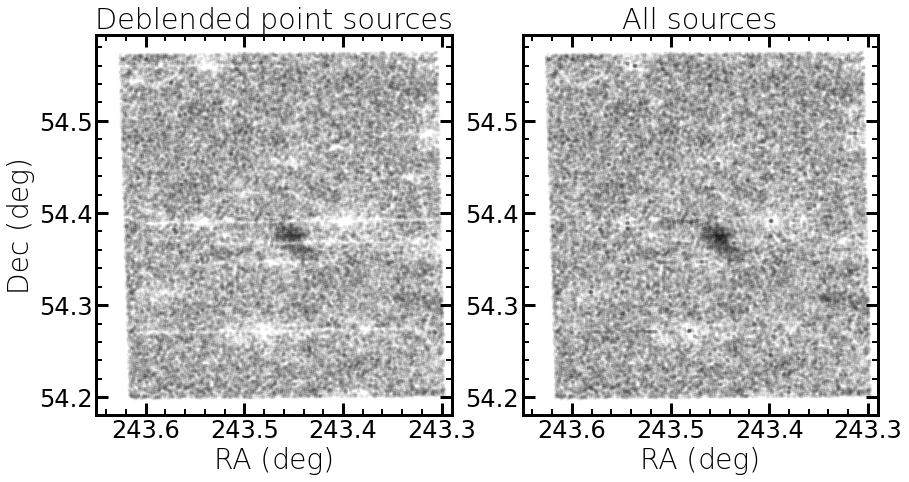

In [81]:
plt.rcParams.update({'figure.figsize' : (14, 7)})

plt.subplot(121)
plt.plot(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource]),np.rad2deg(cat_g['coord_dec'][is_primary & ptsource]),'k.',alpha=0.05)
plt.xlim(243.65,243.29)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.minorticks_on()
plt.title('Deblended point sources')

plt.subplot(122)
plt.plot(np.rad2deg(cat_g['coord_ra'][is_primary]),np.rad2deg(cat_g['coord_dec'][is_primary]),'k.',alpha=0.05)
plt.xlim(243.65,243.29)
plt.title('All sources')
plt.xlabel('RA (deg)')
plt.minorticks_on()

Good - we can see a concentration of sources in the center, which correspond to KKR 25.

## Plot a CMD of objects near KKR 25:

Because the stack uses PanSTARRS-1 (PS1) for photometric calibration, we'll overplot a PS1 isochrone for comparison. This was downloaded from the Padova isochrones web interface (http://stev.oapd.inaf.it/cgi-bin/cmd_3.3).

In [87]:
from astropy.io import ascii

iso = ascii.read('/project/jcarlin/isochrones/parsec12_panstarrs1/0_000500.dat',header_start = 13)

dist = 1.7e6 # in pc # Roughly the distance to KKR 25 (see the NED link above)
ebv = 0.008 # (E(B-V) = 0.008 according to Makarov+2012) -- You could also look this up using the central coordinates.
dmod = 5.0*np.log10(dist) - 5.0 # convert distance to distance modulus

# Raw PS1-band isochrone magnitudes
g_iso_ps1 = iso['gP1']
r_iso_ps1 = iso['rP1']
i_iso_ps1 = iso['iP1']

# Extinction coefficients from Schlafly+2011:
A_g = 3.172 * ebv
A_r = 2.271 * ebv
A_i = 1.682 * ebv

# NOTE: we are *adding* extinction to the isochrone, instead of looking up the values for all stars. We'll work with
#   un-dereddened magnitudes throughout.
g_iso = g_iso_ps1 + dmod + A_g
r_iso = r_iso_ps1 + dmod + A_r
i_iso = i_iso_ps1 + dmod + A_i 

In [85]:
# Select a smaller region around KKR 25:
coord_g = SkyCoord(cat_g['coord_ra']*u.radian, cat_g['coord_dec']*u.radian, frame='icrs')
### Notice in the line above that coordinates in the catalog are in radians by default.

# Calculate the separation (in degrees) of each HSC patch from KKR25:
sep_kkr25 = coord_g.separation(kkr25_pos)

# Select within some small radius:
sel_rad = 2.5 # radius in arcminutes
sel_cen = (sep_kkr25.arcmin < sel_rad)

The following uses the difference in PSF and cmodel magnitudes to select things that are "star-like". See the Bosch+2018 paper on the HSC pipeline (https://ui.adsabs.harvard.edu/abs/2018PASJ...70S...5B/abstract) for info about this. The "classification_extendedness" flag should have taken care of this already, but this is a way of refining that a bit.

In [86]:
# difference in mags (PSF - cmodel)
magdiff_i = mags_i['psfmag'][:,0]-mags_i['modelmag'][:,0]
starsel_i = (np.abs(magdiff_i) < 0.05)

/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


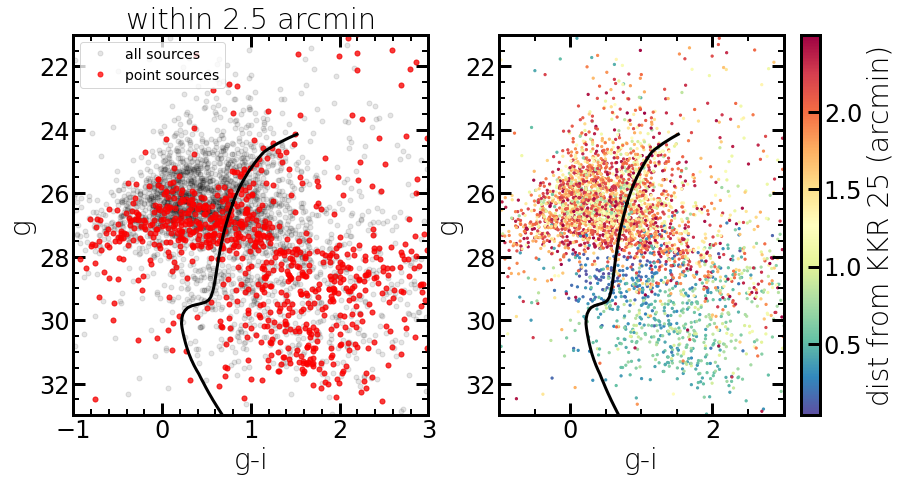

In [92]:
plt.rcParams.update({'figure.figsize' : (14, 7)})

plt.figure()

# The following selects only up to the RGB tip (i.e., no post-RGB, AGB, etc.) from the isochrone, for clarity
okstage = (iso['stage'] <= 3)

plt.subplot(121)
plt.plot(mags_g['psfmag'][is_primary & sel_cen][:,0]-mags_i['psfmag'][is_primary & sel_cen][:,0],\
         mags_g['psfmag'][is_primary & sel_cen][:,0], 'ko', ms=5, alpha=0.1, label='all sources')
plt.plot(mags_g['psfmag'][is_primary & starsel_i & sel_cen][:,0]-mags_i['psfmag'][is_primary & starsel_i & sel_cen][:,0],\
         mags_g['psfmag'][is_primary & starsel_i & sel_cen][:,0], 'ro', ms=5, alpha=0.75, label='point sources')
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k', label='__no label__')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.legend()
plt.xlim(-1,3)
plt.ylim(33,21)
plt.title('within 2.5 arcmin')
plt.minorticks_on()

plt.subplot(122)
plt.scatter(mags_g['psfmag'][is_primary & sel_cen][:,0]-mags_i['psfmag'][is_primary & sel_cen][:,0],\
            mags_g['psfmag'][is_primary & sel_cen][:,0], c=sep_kkr25[is_primary & sel_cen].arcmin, cmap='Spectral_r', s=5)
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.xlim(-1,3)
plt.ylim(33,21)
plt.colorbar(label='dist from KKR 25 (arcmin)')
plt.minorticks_on()
plt.show()
#plt.savefig('cmds_kkr25_noisereplace_on.png')

So, we can see that most of the stars nearest the center of KKR 25 (the blue/green points above) have "bogus" photometry (i.e., g > 28th mag).

Just to confirm that it's stars near KKR 25 that are getting set to unrealistically faint magnitudes, let's plot the positions of objects classified as point sources, color-coded by their g-band PSF magnitude.

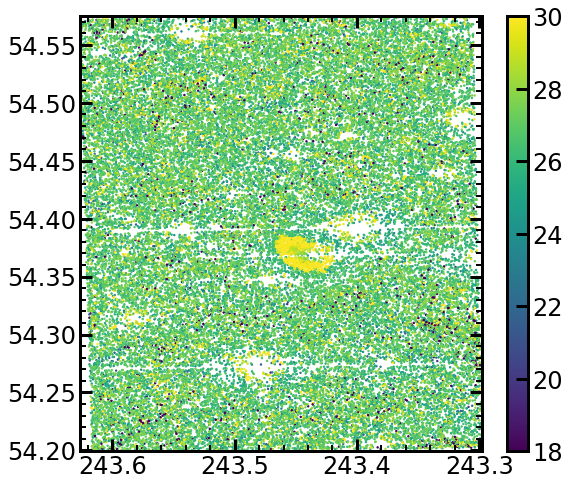

In [94]:
plt.rcParams.update({'figure.figsize' : (9, 8)})

gmags0 = mags_g['psfmag']
gmags0[np.isnan(gmags0)] = 0.0
plt.scatter(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource]),\
            np.rad2deg(cat_g['coord_dec'][is_primary & ptsource]),\
            c=gmags0[is_primary & ptsource][:,0],s=2,vmax=30,vmin=18)
# NOTE: in the above line, gmags0 must be subscripted to select only the magnitude column. gmags0 contains both the
#       magnitudes and their errors, so to get mags only, use gmags0[:0] (for errors, use gmags0[:1])

plt.xlim(np.max(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource])),\
         np.min(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource])))
plt.ylim(np.min(np.rad2deg(cat_g['coord_dec'][is_primary & ptsource])),\
         np.max(np.rad2deg(cat_g['coord_dec'][is_primary & ptsource])))
plt.colorbar()
plt.minorticks_on()

All the sources in KKR25, while detected, seem to have magnitudes >= 30(!).

Plot magnitude vs. position to see if it's true that the g>28 sources are concentrated in KKR25.

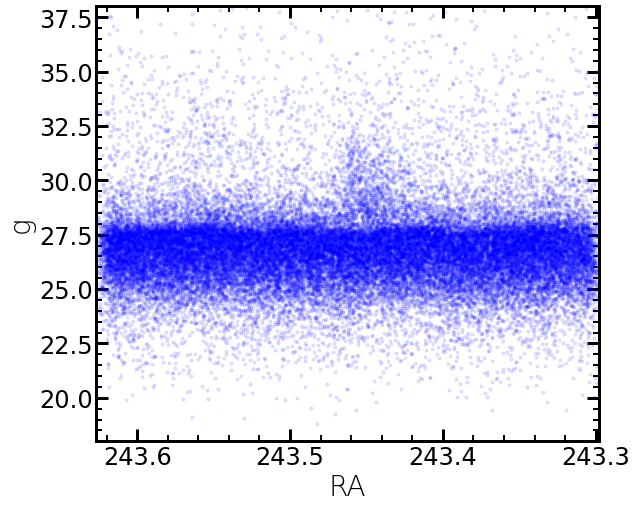

In [97]:
plt.plot(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource]),\
         gmags0[is_primary & ptsource][:,0],'b.',alpha=0.1)
plt.ylim(18,38)
plt.xlim(np.max(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource])),\
         np.min(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource])))
plt.xlabel('RA')
plt.ylabel('g')
plt.minorticks_on()

Sure enough, there is a big blob of objects at RA~243.45, with magnitudes fainter than g>28. So, it looks like the Stack detects sources in the center, but when it measures them, something goes wrong. 

*** STOPPED HERE*** it oversubtracts the background (as you might expect given the crowding and excess background in the galaxy).

## Try using the noise replacer to replace the detection footprints with noise

In [135]:
# Extract the cutout image:
gimgCutout_sub = cutoutImage(raDec, size_arcmin, dr14_g)
iimgCutout_sub = cutoutImage(raDec, size_arcmin, dr14_i)
cat_g_sub, refcat_g_sub, mags_g_sub = cutoutCatalog(raDec, size_arcmin, dr14_g)
cat_i_sub, refcat_i_sub, mags_i_sub = cutoutCatalog(raDec, size_arcmin, dr14_i)

npixels:  1071
cutoutSize:  (1071, 1071)
(6161.1, 19656)
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5626, 19120), dimensions=Extent2I(1072, 980)), 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G'}
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5626, 19900), dimensions=Extent2I(1072, 292)), 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G'}
npixels:  1071
cutoutSize:  (1071, 1071)
(6161.1, 19656)
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5626, 19120), dimensions=Extent2I(1072, 980)), 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-I'}
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5626, 19900), dimensions=Extent2I(1072, 292)), 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-I'}
Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'

In [136]:
#dataref = subset.cache[0]
dataref14 = sub14.cache[0]  #{'tract':df_selected.iloc[0]['tract'],'patch':df_selected.iloc[0]['patch'],'filter':'HSC-G'}
#dataref15 = sub15.cache[0]  #{'tract':df_selected.iloc[0]['tract'],'patch':df_selected.iloc[0]['patch'],'filter':'HSC-G'}

## Source catalog:
cat14 = butler.get('deepCoadd_forced_src', dataId=dataref14)
#cat15 = butler.get('deepCoadd_forced_src', dataId=dataref15)

# Reference object:
ref14 = butler.get('deepCoadd_ref', dataId=dataref14)
#ref15 = butler.get('deepCoadd_ref', dataId=dataref15)

# Calibrated exposure:
calexp14 = butler.get('deepCoadd_calexp', dataId=dataref14)
#calexp15 = butler.get('deepCoadd_calexp', dataId=dataref15)

ADD A REFERENCE TO IMRAN'S FOOTPRINTS NOTEBOOK!

In [137]:
# extract the footprints of all detected sources into a dict:
fp_dict_g = {measRecord.getId(): (measRecord.getParent(), measRecord.getFootprint()) for measRecord in ref14}
#fp_dict_g = {measRecord.getId(): (measRecord.getParent(), measRecord.getFootprint()) for measRecord in refcat_g_sub}

In [138]:
from lsst.meas.base import NoiseReplacer, NoiseReplacerConfig

In [139]:
# Instantiate the NoiseReplacer and feed it the calexp image and the footprints:
nr_config = NoiseReplacerConfig()
noiseReplacer = NoiseReplacer(nr_config, calexp14, fp_dict_g)
#noiseReplacer = NoiseReplacer(nr_config, gimgCutout_sub.exposure, fp_dict_g)

<Figure size 1008x504 with 0 Axes>

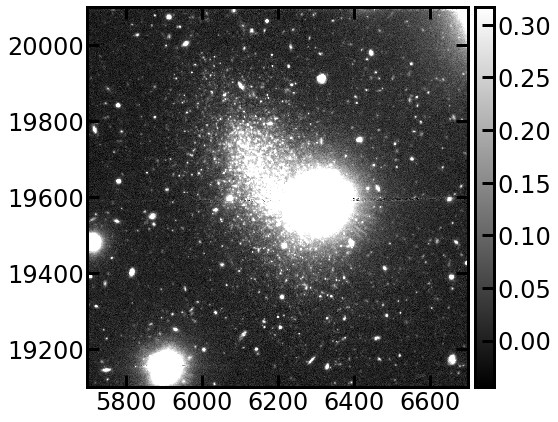

In [140]:
# Display the original image:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('linear', 'zscale')
afw_display.mtv(my_calexp14.getMaskedImage()[5700:6700,19100:20100])

<Figure size 1008x504 with 0 Axes>

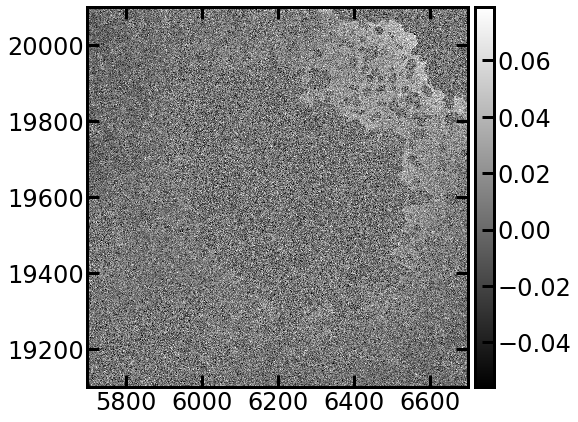

In [141]:
# Display the image with the source footprints replaced by noise:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('linear', 'zscale')
afw_display.mtv(calexp14.getMaskedImage()[5700:6700,19100:20100])

The fact that they subtracted off nicely confirms that the sources in KKR 25 were detected. Now the question is whether one can get measurements for those objects.

### Overlay sources on a zoomed-in region to see where measurement breaks down.

In [143]:
# Extract a small cutout for efficiency:
cutout_pos = SkyCoord(kkr25_pos.ra+(0.5*u.arcmin), kkr25_pos.dec+(0.5*u.arcmin), frame='icrs') # KKR25
raDec_cutout = geom.SpherePoint(cutout_pos.ra.value, cutout_pos.dec.value, geom.degrees)
# Extract the cutout image:
cutout_size = 0.4 # in arcmin
gcutout = cutoutImage(raDec_cutout, cutout_size, dr14_g)
icutout = cutoutImage(raDec_cutout, cutout_size, dr14_i)
gcat, grefcat, gcutout_mags = cutoutCatalog(raDec_cutout, cutout_size, dr14_g)
icat, irefcat, icutout_mags = cutoutCatalog(raDec_cutout, cutout_size, dr14_i)

npixels:  143
cutoutSize:  (143, 143)
(6059.5, 19836)
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5987, 19764), dimensions=Extent2I(145, 144)), 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G'}
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5987, 19900), dimensions=Extent2I(145, 8)), 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G'}
npixels:  143
cutoutSize:  (143, 143)
(6059.5, 19836)
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5987, 19764), dimensions=Extent2I(145, 144)), 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-I'}
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5987, 19900), dimensions=Extent2I(145, 8)), 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-I'}
Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 

In [144]:
### Show the location of the cutout on the full image!

In [145]:
is_primary_cutout = (grefcat['detect_isPrimary'] == True) &\
                    (irefcat['detect_isPrimary'] == True) 
is_finite_cutout = (np.isfinite(gcat.getPsfInstFlux())) & (np.isfinite(icat.getPsfInstFlux()))
deblended_cutout = (gcat['deblend_nChild'] == 0) & (icat['deblend_nChild'] == 0)
magcut_cutout = (gcutout_mags['psfmag'][:,0] < 28.0)
ptsource_cutout = (gcat['base_ClassificationExtendedness_flag'] == False) &\
                  (icat['base_ClassificationExtendedness_flag'] == False)

<Figure size 1008x504 with 0 Axes>

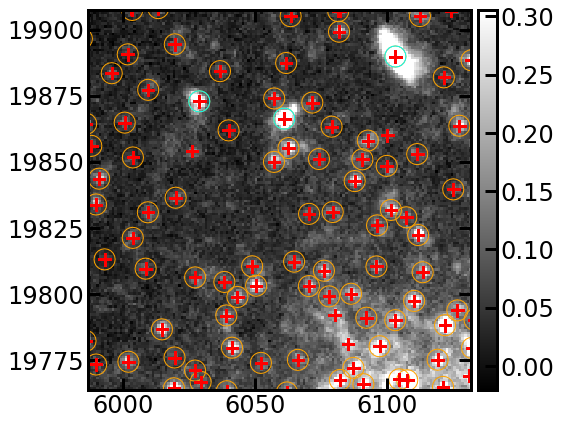

In [146]:
# Display the cutout image:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('linear', 'zscale')
afw_display.mtv(gcutout.exposure.image)

# Use display buffering so the image isn't redrawn every time it plots a source
with afw_display.Buffering():
    for gsrc in gcat:
        afw_display.dot('+', gsrc.getX(), gsrc.getY(), ctype='red')
#        afw_display.dot('o', gsrc.getX(), gsrc.getY(), size=5, ctype='cyan')
    for gsrc2 in gcat[is_primary_cutout & is_finite_cutout & ptsource_cutout]:
#    for gsrc2 in gcat[is_primary_cutout & is_finite_cutout & deblended_cutout & ptsource_cutout]:
        afw_display.dot('o', gsrc2.getX(), gsrc2.getY(), size=4, ctype='orange')
    for gsrc3 in gcat[is_primary_cutout & is_finite_cutout & ptsource_cutout & magcut_cutout]:
#    for gsrc3 in gcat[is_primary_cutout & is_finite_cutout & deblended_cutout & ptsource_cutout & magcut_cutout]:
        afw_display.dot('o', gsrc3.getX(), gsrc3.getY(), size=4, ctype='cyan')


<Figure size 1008x504 with 0 Axes>

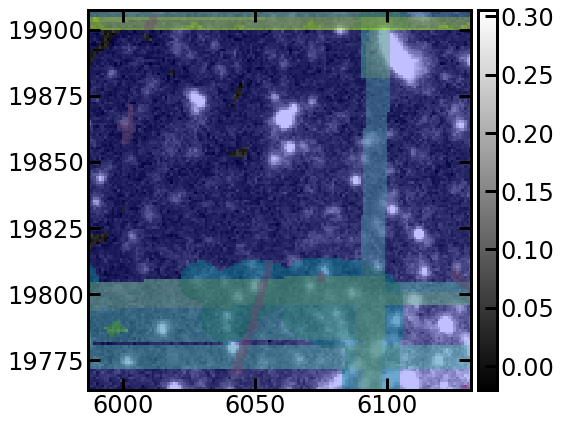

In [147]:
# Display the cutout image:
plt.figure()
afw_display = afwDisplay.Display()
#afw_display.setMaskTransparency(100)
afw_display.scale('linear', 'zscale')
afw_display.mtv(gcutout.exposure.maskedImage)


Text(0, 0.5, 'detected objects (arcmin$^{-2}$)')

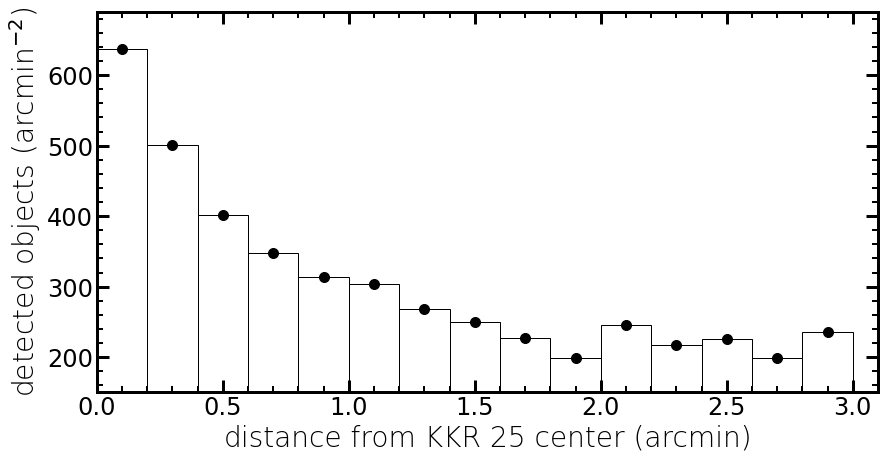

In [148]:
binwidth_arcmin = 0.2
radial_bins = np.arange(0, 3.1, binwidth_arcmin)
area_inside = np.pi*(radial_bins**2)
area_bin = 0.0*area_inside
for i in range(len(area_bin)-1):
    area_bin[i] = area_inside[i+1] - area_inside[i]
num_per_bin = np.histogram(sep_kkr25.arcmin, bins=radial_bins)
densities = num_per_bin[0]/area_bin[:-1]

plt.plot(num_per_bin[1][:-1]+binwidth_arcmin/2, densities, 'k.', ms=20)
plt.bar(num_per_bin[1][:-1]+binwidth_arcmin/2, densities, width=binwidth_arcmin, fill=False)
plt.xlim(0,3.1)
plt.ylim(150,690)
plt.minorticks_on()
plt.xlabel('distance from KKR 25 center (arcmin)')
plt.ylabel(r'detected objects (arcmin$^{-2}$)')
#plt.hist(sep_kkr25.arcmin,bins=np.arange(0,3.1,0.1))

The profile is peaked at KKR 25, also confirming that it is detected by the Stack, but simply not well measured.

In [149]:
# X: 5970-6130, Y: 19775-19905
xmin = 5970
xmax = 6130
ymin = 19775
ymax = 19905
keep14 = (ref14.getX() < xmax) & (ref14.getX() > xmin) & (ref14.getY() < ymax) & (ref14.getY() > ymin)
ref14keep = ref14[keep14]
fp_dict_g14 = {measRecord.getId(): (measRecord.getParent(), measRecord.getFootprint()) for measRecord in ref14keep}
srcids14 = ref14keep['id']

In [150]:
srcids14[21]

75338691354075132

In [151]:
#shp_xx, shp_xy, shp_yy = gcat.getIxx(), gcat.getIxy(), gcat.getIyy()
shp_xx = grefcat['ext_shapeHSM_HsmSourceMoments_xx']
shp_yy = grefcat['ext_shapeHSM_HsmSourceMoments_yy']
shp_xy = grefcat['ext_shapeHSM_HsmSourceMoments_xy']
theta = np.arctan2(2. * shp_xy, shp_xx - shp_yy) / 2.
e1 = (shp_xx - shp_yy) / (shp_xx + shp_yy)
e2 = (2. * shp_xy) / (shp_xx + shp_yy)
theta_alternate = np.arctan2(e2, e1) / 2.
e = np.sqrt(e1**2 + e2**2)
ex = e * np.cos(theta)
ey = e * np.sin(theta)
trace = np.sqrt((shp_xx + shp_yy) / 2.) # This is the "trace radius"
det = (shp_xx * shp_yy - shp_xy**2)**(1. / 4.) # Determinant radius

In [152]:
print(trace[0:3], det[0:3])

[       nan 3.78268436 1.30198984] [       nan 3.47281909 1.21715975]


In [153]:
np.shape(gcutout_mags['psfmag'][:,0])

(61007,)

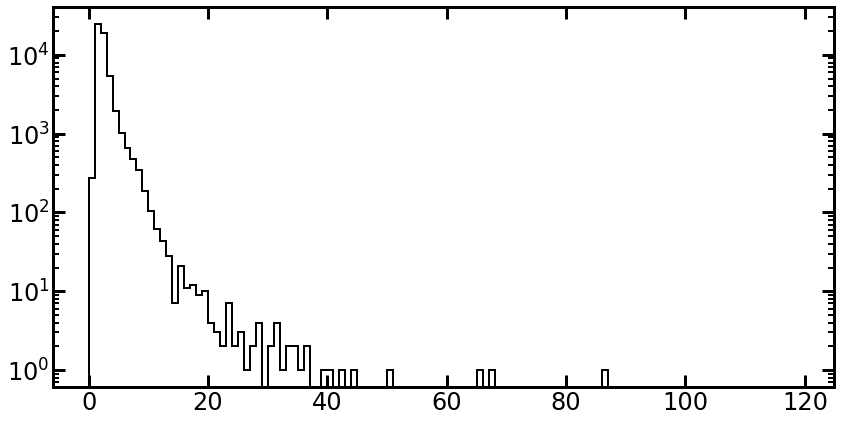

In [154]:
#size = np.sqrt(shp_xx**2 + shp_yy**2)
#plt.hist(shp_xx, bins=np.arange(0,1000,5), color='Red', log=True, histtype='step', linewidth=2)
#plt.hist(shp_yy, bins=np.arange(0,1000,5), color='Blue', log=True, histtype='step', linewidth=2)
plt.hist(trace, bins=np.arange(0,120,1), color='Black', log=True, histtype='step', linewidth=2)
#plt.hist(size, bins=np.arange(0,12000,10), color='Black', log=True, histtype='step', linewidth=2)
plt.show()

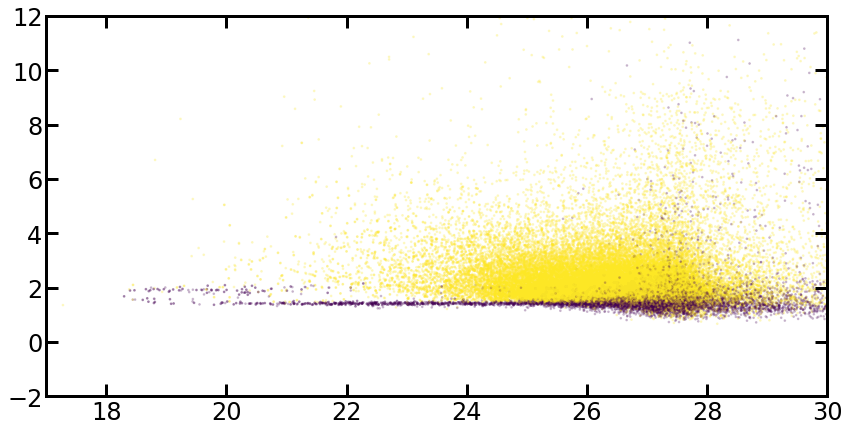

In [155]:
plt.scatter(gcutout_mags['psfmag'][:,0],trace,c=gcat['base_ClassificationExtendedness_value'],alpha=0.2,s=3)
plt.xlim(17,30)
plt.ylim(-2,12)
#plt.colorbar()
plt.show()

In [156]:
# ref14.schema

Want to find the *objects* that are very large to see if that's what we need to remove. Presumably some parameter from the CModel measurements is what we need?

In [157]:
# ref14keep[21]

In [158]:
#for i in range(len(grefcat)):
#    print(trace[i], grefcat[i]['base_FootprintArea_value'], grefcat[i]['base_ClassificationExtendedness_value'],\
#          gcutout_mags[i]['psfmag'][0], gcutout_mags[i]['modelmag'][0])
##    print(obj['modelfit_CModel_region_final_ellipse_xx'], obj['modelfit_CModel_region_final_ellipse_yy'], obj['base_FootprintArea_value'])

In [159]:
c14 = my_calexp14.clone()

# Instantiate the NoiseReplacer and feed it the calexp image and the footprints:
nr_config = NoiseReplacerConfig()
noiseReplacer = NoiseReplacer(nr_config, c14, fp_dict_g14)
#for s in srcids14:
#    noiseReplacer.insertSource(s)

#noiseReplacer = NoiseReplacer.removeSource(srcids14[0])
ind = 53 # 33 # 53, 55, 56 are huge!
noiseReplacer.insertSource(srcids14[ind])
print('(X,Y): ', ref14keep[ind].getX(), ref14keep[ind].getY())
#noiseReplacer = NoiseReplacer(nr_config, gimgCutout_sub.exposure, fp_dict_g)

(X,Y):  6026.0 19854.0


In [160]:
# Check the area of the footprint we've selected:
srctmp = ref14keep[ind]
fprtmp = srctmp.getFootprint()
print(fprtmp.getArea())

9527


In [161]:
fp = fp_dict_g14[srcids14[ind]][1].getSpans().unflatten(fp_dict_g14[srcids14[ind]][1].getImageArray())
fp_bbox = fp_dict_g14[srcids14[ind]][1].getBBox()

In [162]:
fp_bbox.getBeginX()

5982

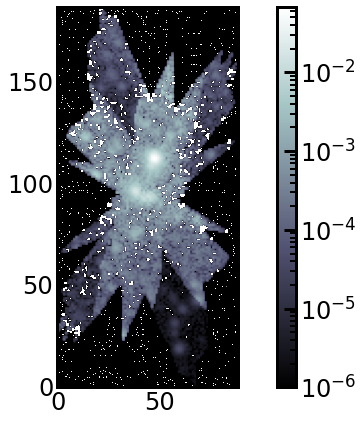

In [163]:
from matplotlib.colors import LogNorm
#fp_dict_g14[srcids14[ind]][1].isHeavy()
#fp = fp_dict_g14[srcids14[ind]][1].getSpans().unflatten(fp_dict_g14[srcids14[ind]][1].getImageArray())
#plt.imshow(fp_dict_g14[srcids14[ind]][1].getSpans().unflatten(fp_dict_g14[srcids14[ind]][1].getImageArray()),
plt.imshow(fp,
#           cmap='bone', origin='lower')#, vmin=0.1*fp.min(), vmax=0.1*fp.max())
           cmap='bone', origin='lower', norm=LogNorm(vmin=1e-6, vmax=fp.max()))
plt.colorbar()

Text(0, 0.5, 'number of sources')

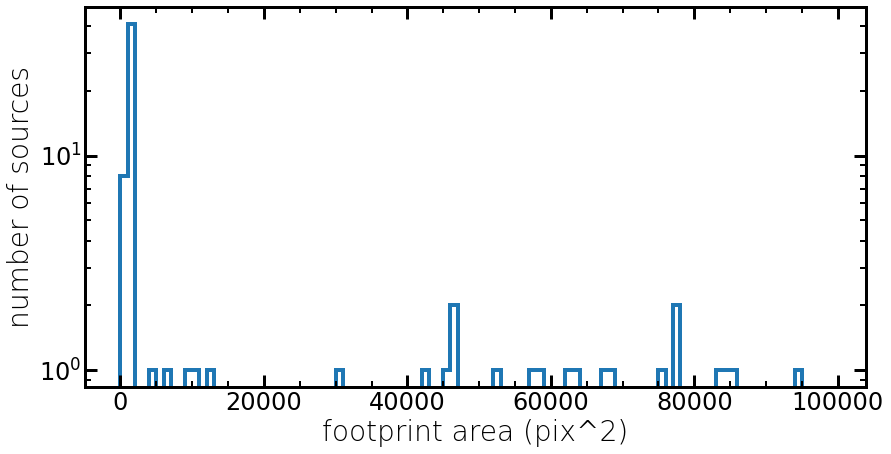

In [164]:
areas = []

for src in ref14keep:
    src_area = src.getFootprint().getArea()
    areas.append(src_area)
    
plt.hist(areas, bins=np.arange(0,1e5,1e3),log=True, histtype='step', linewidth=4)
plt.minorticks_on()
plt.xlabel('footprint area (pix^2)')
plt.ylabel('number of sources')

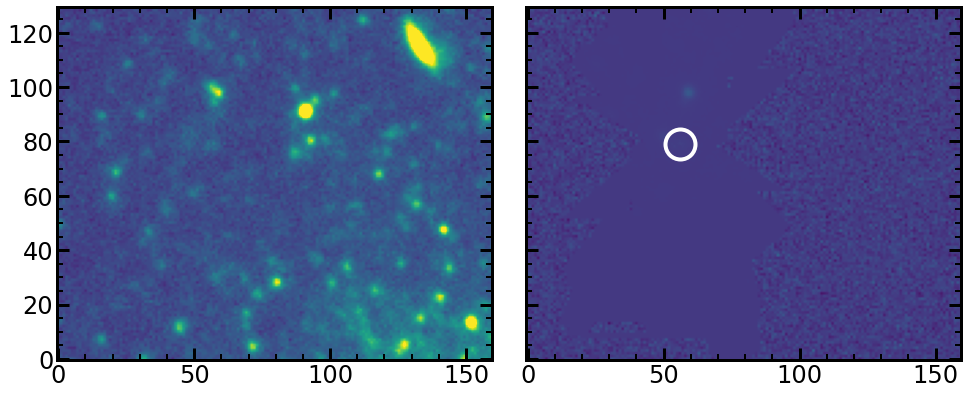

In [165]:
f, ax = plt.subplots(nrows=1, ncols=2, sharey=True)

axflat = ax.flatten()
ax1 = axflat[0]
ax2 = axflat[1]
data = my_calexp14.getMaskedImage()[xmin:xmax,ymin:ymax].getImage().array
#ax1.set_xlim(xmin, xmax)
#ax1.set_ylim(ymin, ymax)
ax1.minorticks_on()
ax1.imshow(data, origin='lower',vmin=-0.1, vmax=0.5)

data = c14.getMaskedImage()[xmin:xmax,ymin:ymax].getImage().array
ax2.imshow(data, origin='lower',vmin=-0.1, vmax=0.5)
ax2.plot(ref14keep[ind].getX()-xmin, ref14keep[ind].getY()-ymin, 'o', ms=30, color='white', fillstyle='none', markeredgewidth=4)
#ax2.set_xlim(xmin, xmax)
#ax2.set_ylim(ymin, ymax)
ax2.minorticks_on()
plt.tight_layout()

<Figure size 1008x504 with 0 Axes>

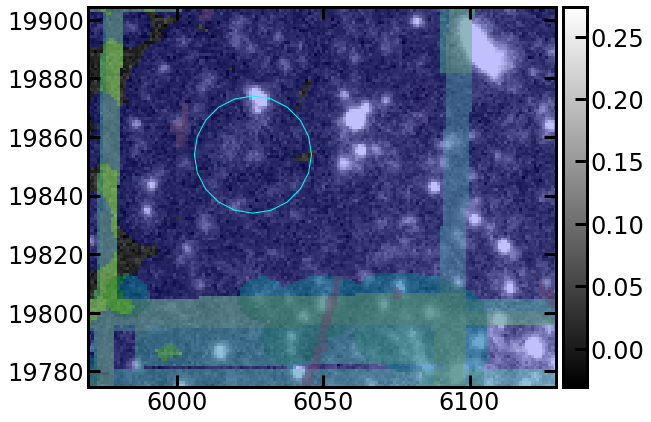

In [166]:
# Display the cutout image:
plt.figure()
afw_display = afwDisplay.Display()
#afw_display.setMaskTransparency(100)
afw_display.scale('linear', 'zscale')
afw_display.mtv(my_calexp14.getMaskedImage()[xmin:xmax,ymin:ymax])
afw_display.dot('o', ref14keep[ind].getX(), ref14keep[ind].getY(), size=20, ctype='cyan')

/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less


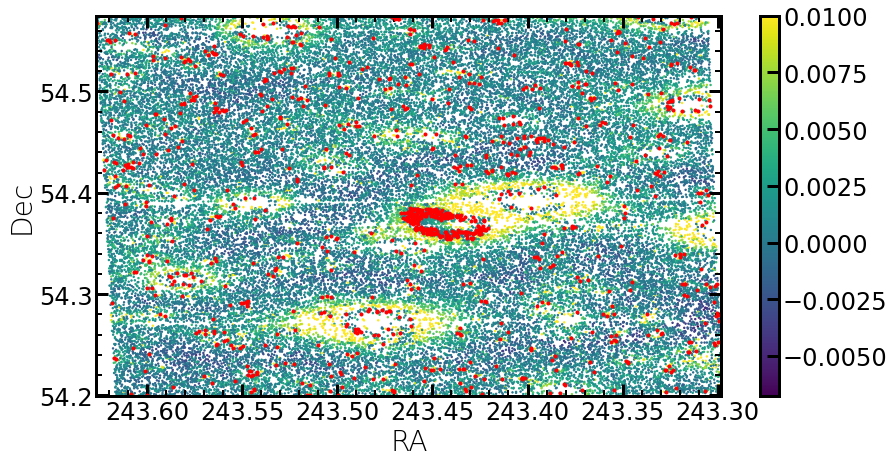

In [167]:
plt.scatter(np.rad2deg(cat_g['coord_ra'][is_primary & deblended & ptsource]),\
            np.rad2deg(cat_g['coord_dec'][is_primary & deblended & ptsource]),\
#            c=cat_g[is_primary & deblended & ptsource]['base_PsfFlux_flux'],s=2,vmax=1)
            c=cat_g[is_primary & deblended & ptsource]['base_LocalBackground_flux'],s=2,vmax=0.01)

#zerobg = (cat_g['base_PsfFlux_flux'] < 0.5)
zerobg = (np.abs(cat_g['base_LocalBackground_flux']) < 1.0e-6)

plt.plot(np.rad2deg(cat_g['coord_ra'][is_primary & deblended & ptsource & zerobg]),\
         np.rad2deg(cat_g['coord_dec'][is_primary & deblended & ptsource & zerobg]), 'r.')

plt.xlim(np.max(np.rad2deg(cat_g['coord_ra'][is_primary & deblended & ptsource])),\
         np.min(np.rad2deg(cat_g['coord_ra'][is_primary & deblended & ptsource])))
plt.ylim(np.min(np.rad2deg(cat_g['coord_dec'][is_primary & deblended & ptsource])),\
         np.max(np.rad2deg(cat_g['coord_dec'][is_primary & deblended & ptsource])))
plt.colorbar()
plt.xlabel('RA')
plt.ylabel('Dec')
plt.minorticks_on()

So this makes it seem that the issue is the background and PSF/Gaussian/Aperture fluxes being estimated to be zero (or very small). 

Text(0, 0.5, 'PSF flux')

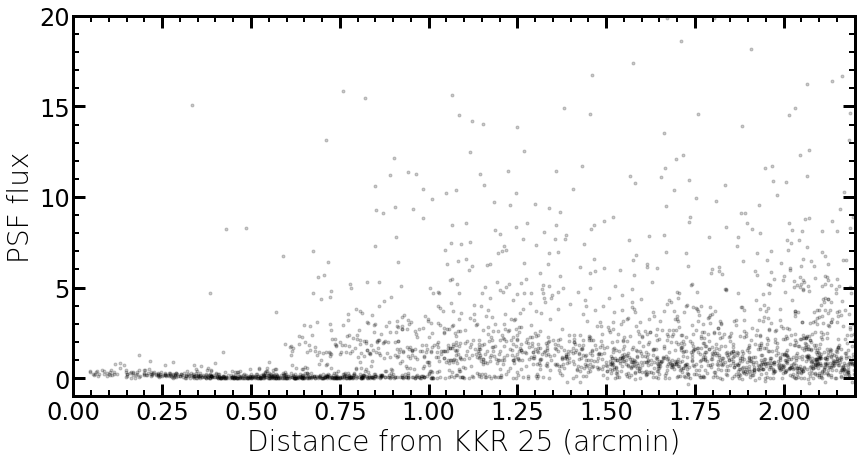

In [168]:
#plt.hist(cat_g[is_primary & deblended & ptsource]['base_CircularApertureFlux_3_0_flux'],bins=100,log=True)#,range=[-0.01,0.02])
plt.plot(sep_kkr25[is_primary & deblended & ptsource].arcmin,\
#         cat_g[is_primary & deblended & ptsource]['base_CircularApertureFlux_3_0_flux'],'k.',alpha=0.2)
         cat_g[is_primary & deblended & ptsource]['base_PsfFlux_flux'],'k.',alpha=0.2)
plt.xlim(0,2.2)
plt.ylim(-1,20)
plt.minorticks_on()
plt.xlabel('Distance from KKR 25 (arcmin)')
plt.ylabel('PSF flux')

In [169]:
grefcat.schema()

TypeError: 'lsst.afw.table._table.Schema' object is not callable

### Re-run forced photometry, but without replacing all the footprints with noise:

In [268]:
from lsst.pipe.tasks.multiBand import DetectCoaddSourcesTask, DetectCoaddSourcesConfig
from lsst.pipe.tasks.multiBand import MeasureMergedCoaddSourcesTask, MeasureMergedCoaddSourcesConfig

In [275]:
mcfg = MeasureMergedCoaddSourcesConfig()
mcfg.measurement.doReplaceWithNoise = False

In [279]:
deepCoadd_calexp = butler.get("deepCoadd_calexp", dataId={'filter': 'HSC-I', 'tract': 17130, 'patch': '1,4'})
deepCoadd_mergeDet = butler.get("deepCoadd_mergeDet", dataId={'tract': 17130, 'patch': '1,4'})

schema = afwTable.SourceTable.makeMinimalSchema()

#dcconfig = DetectCoaddSourcesConfig()

/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


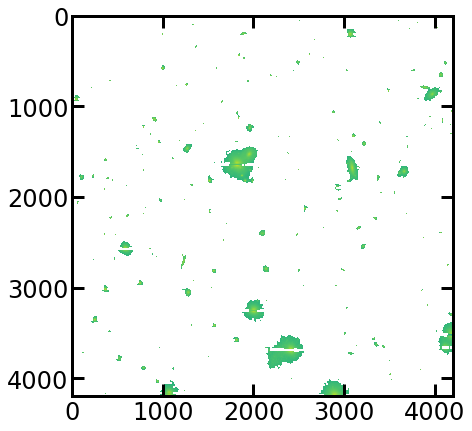

In [277]:
plt.imshow(np.log10(deepCoadd.image.array))

In [290]:
#MeasureMergedCoaddSourcesTask?
mTask = MeasureMergedCoaddSourcesTask(schema=schema, config=mcfg)

tab = afwTable.SourceTable.make(schema)
# detection needs this to be happy
# you can pass none for exposure id
idFactory = afwTable.IdFactory.makeSimple()
result = mTask.run(deepCoadd_calexp, deepCoadd_mergeDet)

TypeError: run() missing 2 required positional arguments: 'skyInfo' and 'exposureId'

In [289]:
mTask.run?

Signature:
mTask.run(
    exposure,
    sources,
    skyInfo,
    exposureId,
    ccdInputs=None,
    visitCatalogs=None,
    wcsUpdates=None,
    butler=None,
)
Docstring:
Run measurement algorithms on the input exposure, and optionally populate the
resulting catalog with extra information.

Parameters
----------
exposure : `lsst.afw.exposure.Exposure`
    The input exposure on which measurements are to be performed
sources :  `lsst.afw.table.SourceCatalog`
    A catalog built from the results of merged detections, or
    deblender outputs.
skyInfo : `lsst.pipe.base.Struct`
    A struct containing information about the position of the input exposure within
    a `SkyMap`, the `SkyMap`, its `Wcs`, and its bounding box
exposureId : `int` or `bytes`
    packed unique number or bytes unique to the input exposure
ccdInputs : `lsst.afw.table.ExposureCatalog`
    Catalog containing information on the individual visits which went into making
    the exposure
visitCatalogs : list of `lsst.afw.

In [216]:
# subaru configs and in detectcoaddsources defaults
# recall we drill down in the config to the detection subtask
# and its parameters to set them
#dcconfig.detection.isotropicGrow = True
#dcconfig.detection.doTempWideBackground =   True
#dcconfig.detection.tempWideBackground.binSize = 128
#dcconfig.detection.tempWideBackground.useApprox = False
#dcconfig.detection.reEstimateBackground = True
#dcconfig.detection.background.binSize = 128
#dcconfig.detection.background.useApprox = False
#dcconfig.detection.thresholdType = "pixel_stdev"

sourceCoaddDetectionTask = DetectCoaddSourcesTask(schema=schema, config=dcconfig)

tab = afwTable.SourceTable.make(schema)
# detection needs this to be happy
# you can pass none for exposure id
idFactory = afwTable.IdFactory.makeSimple()
result = sourceCoaddDetectionTask.run(deepCoadd, idFactory, None)

In [220]:
forcedPhotCoaddTask?

Object `forcedPhotCoaddTask` not found.


In [222]:
from lsst.pipe.drivers.multiBandDriver import MultiBandDriverConfig

In [234]:
mbconf = MultiBandDriverConfig()

In [265]:
mbconf.measureCoaddSources.measurement.items()

[('slots',
  lsst.meas.base.baseMeasurement.SourceSlotConfig(centroid='base_SdssCentroid', shape='base_SdssShape', psfShape='base_SdssShape_psf', apFlux='base_CircularApertureFlux_12_0', modelFlux='base_GaussianFlux', psfFlux='base_PsfFlux', gaussianFlux='base_GaussianFlux', calibFlux='base_CircularApertureFlux_12_0')),
 ('doReplaceWithNoise', True),
 ('noiseReplacer',
  lsst.meas.base.noiseReplacer.NoiseReplacerConfig(noiseSource='measure', noiseOffset=0.0, noiseSeedMultiplier=1)),
 ('undeblendedPrefix', 'undeblended_'),
 ('plugins',
  <lsst.pex.config.registry.RegistryInstanceDict at 0x7ff5d03bb1d0>),
 ('undeblended',
  <lsst.pex.config.registry.RegistryInstanceDict at 0x7ff5d03bb390>)]

In [170]:
from lsst.meas.base import ForcedPhotCoaddTask, ForcedPhotImageTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask

In [171]:
cfg = ForcedPhotImageTask.ConfigClass()
cfg.measurement.doReplaceWithNoise = False

In [172]:
forcedMeasTask = ForcedPhotCoaddTask(butler=butler, config=cfg)

In [173]:
calexp_meas14 = my_calexp14.clone()
cat_meas14 = cat14[keep14][0:3]
ref_meas14 = ref14

In [174]:
# calexp_meas14 is the calexp, cat_meas14 is the forced_src catalog:

##### This runs out of memory and kills the kernel/process...

#forcedMeasTask.run(measCat=cat_meas14, exposure=calexp_meas14, refCat=ref_meas14, refWcs=calexp_meas14.getWcs())

In [175]:
#cfg = SingleFrameMeasurementTask.ConfigClass()
#cfg = ForcedPhotCoaddTask.ConfigClass()
#cfg = ForcedPhotImageTask.ConfigClass()

In [176]:
#cfg.doReplaceWithNoise = False

In [177]:
#schema = afwTable.SourceTable.makeMinimalSchema()
#tab = afwTable.SourceTable.make(schema)
#
#algMetadata = dafBase.PropertyList()
#
#config = SingleFrameMeasurementTask.ConfigClass()
#config.doReplaceWithNoise = False
#sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config, algMetadata=algMetadata)

In [178]:
##srcs = grefcat.getTable
#srcs = afwTable.SourceTable.clone(grefcat.table)
#gcalexp_clean = gcutout.exposure.clone()
#sourceMeasurementTask.run(measCat=srcs, exposure=gcalexp_clean)

In [85]:
gcat2 = gcat.copy(deep=True)
children = []
gcat2.sort(gcat2.getParentKey())
for gg in gcat2[-40:]:
    #gg = gcat2[-1]
    parent_tmp = gg.getParent()
    if parent_tmp != 0:
        children_tmp = gcat2.getChildren(parent_tmp)['id']
    else: children_tmp = np.zeros(1)
    children.append(children_tmp)

In [86]:
children

[array([75338695649047319, 75338695649047320], dtype=int64),
 array([75338695649047321, 75338695649047322], dtype=int64),
 array([75338695649047321, 75338695649047322], dtype=int64),
 array([75338695649047323, 75338695649047324], dtype=int64),
 array([75338695649047323, 75338695649047324], dtype=int64),
 array([75338695649047325, 75338695649047326], dtype=int64),
 array([75338695649047325, 75338695649047326], dtype=int64),
 array([75338695649047327, 75338695649047328, 75338695649047329],
       dtype=int64),
 array([75338695649047327, 75338695649047328, 75338695649047329],
       dtype=int64),
 array([75338695649047327, 75338695649047328, 75338695649047329],
       dtype=int64),
 array([75338695649047330, 75338695649047331], dtype=int64),
 array([75338695649047330, 75338695649047331], dtype=int64),
 array([75338695649047332, 75338695649047333], dtype=int64),
 array([75338695649047332, 75338695649047333], dtype=int64),
 array([75338695649047334, 75338695649047335], dtype=int64),
 array(

In [87]:
### Is the answer that the deblender is making one giant deblend out of KKR 25? So that all the sources are children? 
### Then when the flux measurements are done and the NoiseReplacer is used to remove children, it means nothing gets left...

# More exploration

- Are there reasonable aperture mags in the catalogs?
- Look at the footprints of detections in some zoomed-in region(s).
- Can we re-run detection and measurement with a different background scale to recover the stars nearer the center?
- ...or with the deblender assuming everything is a star?
- Check out the mask plane?
- How about masking the detected objects, smoothing, then subtracting off a simple Sersic model galaxy. Then when we add the sources back in it should be easier to measure them.

In [88]:
def cutoutCatalog_ApMags(raDec, size_arcmin, filter):
    '''
    Function to extract an catalog cutout, including aperture magnitudes.
    Inputs:
      raDec: an afwGeom.SpherePoint object with desired RA, Dec center 
      size_arcmin: desired image size (in arcminutes)
      filter: desired filter of extracted image (string)
    '''
# Start with a center position and make a bbox centered there, and expand it to include data from neighboring patches:
    skyMap =  butler.get("deepCoadd_skyMap", immediate=True, tract=tract, patch=patch, filter=filter)
    tmp_calexp = butler.get("deepCoadd_calexp", immediate=True, tract=tract, patch=patch, filter=filter)
    expWcs = tmp_calexp.getWcs()

    size_pixels = arcmin2pix(size_arcmin)
    cutoutSize = geom.ExtentI(size_pixels, size_pixels) # size of cutout in pixels
    xy = geom.Point2I(expWcs.skyToPixel(raDec)) # central XY coordinate of our star's RA, Dec position
    
# Create the bounding box:
    bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)
    bbox = geom.Box2D(bbox)

    tractInfo = skyMap.findTract(raDec)
    skyCorners = [expWcs.pixelToSky(pixPos) for pixPos in bbox.getCorners()]
    patchList = tractInfo.findPatchList(skyCorners)
    print('Npatches: ',len(patchList))

    nPatchesFound = 0
    for patchInfo in patchList:
        patchArgDict = dict(
                            datasetType="deepCoadd_forced_src",
                            tract=tractInfo.getId(),
                            patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                            filter = filter,
                            flags=afwTable.SOURCE_IO_NO_FOOTPRINTS
                            )
        print("Reading patch %s" % patchArgDict)
        src = butler.get(**patchArgDict)
        nPatchesFound += 1

        patchArgDict_ref = dict(
                                datasetType="deepCoadd_ref",
                                tract=tractInfo.getId(),
                                patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                                filter = filter,
                                flags=afwTable.SOURCE_IO_NO_FOOTPRINTS
                                )
        print("Reading ref cat for patch %s" % patchArgDict_ref)
        refcat = butler.get(**patchArgDict_ref)

        patchArgDict_calib = dict(
                                datasetType="deepCoadd_calexp_photoCalib",
                                tract=tractInfo.getId(),
                                patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                                filter = filter,
                                flags=afwTable.SOURCE_IO_NO_FOOTPRINTS
                                )
        print("Reading calib for patch %s" % patchArgDict_calib)
        calib = butler.get(**patchArgDict_calib)
#        calib.setThrowOnNegativeFlux(False)
        psfmags = calib.instFluxToMagnitude(src, 'base_PsfFlux')
        psfmags_un = calib.instFluxToMagnitude(src, 'undeblended_base_PsfFlux')
        modelmags = calib.instFluxToMagnitude(src, 'modelfit_CModel')
        apmags_3_0 = calib.instFluxToMagnitude(src, 'base_CircularApertureFlux_3_0')
        apmags_3_0_un = calib.instFluxToMagnitude(src, 'undeblended_base_CircularApertureFlux_3_0')
        apmags_4_5 = calib.instFluxToMagnitude(src, 'base_CircularApertureFlux_4_5')
        apmags_4_5_un = calib.instFluxToMagnitude(src, 'undeblended_base_CircularApertureFlux_4_5')
        apmags_6_0 = calib.instFluxToMagnitude(src, 'base_CircularApertureFlux_6_0')
        apmags_6_0_un = calib.instFluxToMagnitude(src, 'undeblended_base_CircularApertureFlux_6_0')
        
#        psfmags = calib.instFluxToMagnitude(src.getPsfInstFlux())
#        modelmags = calib.instFluxToMagnitude(src.getModelInstFlux())
        
        # Use astropy 'hstack' to glom the mags onto the src catalog
        #src_all = src #.asAstropy()
        #src_all.extend(psfmags)
        #src_all['psfmag'] = psfmags
        #src_all['modelmag'] = modelmags
        #hstack([src.asAstropy(), Table(psfmags)])
        mags = Table()
        mags['psfmag'] = psfmags
        mags['psfmag_un'] = psfmags_un
        mags['modelmag'] = modelmags
        mags['apmag_3_0'] = apmags_3_0
        mags['apmag_3_0_un'] = apmags_3_0_un
        mags['apmag_4_5'] = apmags_4_5
        mags['apmag_4_5_un'] = apmags_4_5_un
        mags['apmag_6_0'] = apmags_6_0
        mags['apmag_6_0_un'] = apmags_6_0_un


        if nPatchesFound == 1:
            print('patch: 1')
            tmp_src = src
            tmp_ref = refcat
            tmp_mags = mags
            tmp_calib = calib
        else:
            print('patch: ',nPatchesFound)
            tmp_src.extend(src)
            tmp_ref.extend(refcat)
            tmp_mags = vstack([tmp_mags,mags])
            
        print('length of tmp_src, tmp_ref, tmp_mags: ',len(tmp_src),len(tmp_ref), len(tmp_mags))


    print('Making deep copies')
    cat_final = tmp_src.copy(deep = True)
    ref_final = tmp_ref.copy(deep = True)


    if nPatchesFound == 0:
        raise RuntimeError("No patches found!")

    return cat_final, ref_final, tmp_mags

In [89]:
cat_g_ap, refcat_g_ap, mags_g_ap = cutoutCatalog_ApMags(raDec, size_arcmin, 'HSC-G')
cat_i_ap, refcat_i_ap, mags_i_ap = cutoutCatalog_ApMags(raDec, size_arcmin, 'HSC-I')

Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading calib for patch {'datasetType': 'deepCoadd_calexp_photoCalib', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
patch: 1
length of tmp_src, tmp_ref, tmp_mags:  30285 30285 30285
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
Reading calib for patch {'datasetType': 'deepCoadd_calexp_photoCalib', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
patch:  2
length of tmp_src, tmp_ref, tmp_mags:  61007 61007 61007
Making deep copies
Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch

/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in subtract


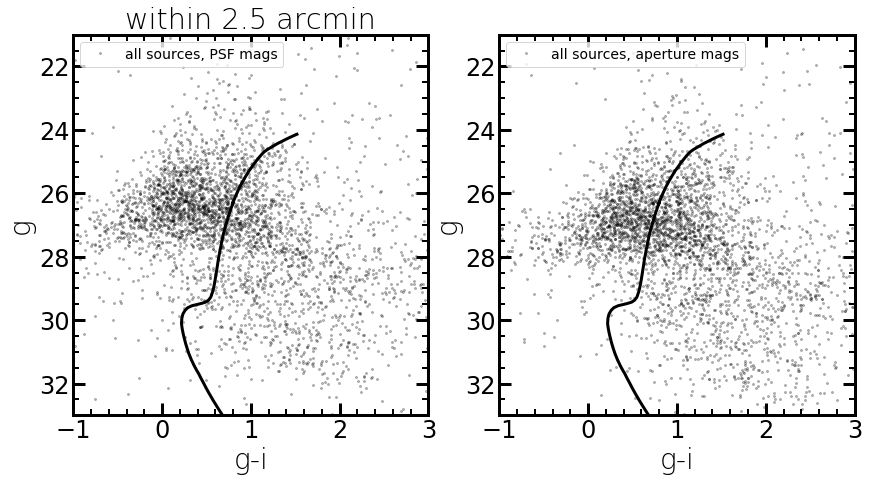

In [90]:
plt.rcParams.update({'figure.figsize' : (14, 7)})

plt.figure()

okstage = (iso['stage'] <= 3)

plt.subplot(121)
#plt.plot(mags_g_ap['apmag_3_0_un'][is_primary & deblended & sel_cen][:,0]-mags_i_ap['apmag_3_0_un'][is_primary & deblended & sel_cen][:,0],\
#         mags_g_ap['apmag_3_0_un'][is_primary & deblended & sel_cen][:,0], 'ko', ms=5, alpha=0.1, label='all sources, aperture mag')
#plt.plot(mags_g_ap['psfmag_un'][is_primary & deblended & starsel_i & sel_cen][:,0]-mags_i_ap['psfmag_un'][is_primary & deblended & starsel_i & sel_cen][:,0],\
#         mags_g_ap['psfmag_un'][is_primary & deblended & starsel_i & sel_cen][:,0], 'ro', ms=5, alpha=0.75, label='point sources')
#plt.plot(mags_g_ap['apmag_3_0_un'][is_primary & deblended & sel_cen][:,0]-mags_i_ap['apmag_3_0_un'][is_primary & deblended & sel_cen][:,0],\
#         mags_g_ap['apmag_3_0_un'][is_primary & deblended & sel_cen][:,0], 'ko', ms=5, alpha=0.1, label='all sources, aperture mag')
#plt.plot(mags_g_ap['apmag_3_0_un'][is_primary & deblended & starsel_i & sel_cen][:,0]-mags_i_ap['apmag_3_0_un'][is_primary & deblended & starsel_i & sel_cen][:,0],\
#         mags_g_ap['apmag_3_0_un'][is_primary & deblended & starsel_i & sel_cen][:,0], 'ro', ms=5, alpha=0.75, label='point sources')
plt.plot(mags_g_ap['psfmag'][is_primary & deblended & sel_cen][:,0]-mags_i_ap['psfmag'][is_primary & deblended & sel_cen][:,0],\
         mags_g_ap['psfmag'][is_primary & deblended & sel_cen][:,0], 'ko', ms=2, alpha=0.25, label='all sources, PSF mags')
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k', label='__no label__')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.legend()
plt.xlim(-1,3)
plt.ylim(33,21)
plt.title('within 2.5 arcmin')
plt.minorticks_on()

plt.subplot(122)
plt.plot(mags_g_ap['apmag_3_0'][is_primary & deblended & sel_cen][:,0]-mags_i_ap['apmag_3_0'][is_primary & deblended & sel_cen][:,0],\
         mags_g_ap['apmag_3_0'][is_primary & deblended & sel_cen][:,0], 'ko', ms=2, alpha=0.25, label='all sources, aperture mags')
#plt.scatter(mags_g_ap['psfmag_un'][is_primary & sel_cen][:,0]-mags_i_ap['psfmag_un'][is_primary & sel_cen][:,0],\
#            mags_g_ap['psfmag_un'][is_primary & sel_cen][:,0], c=sep_kkr25[is_primary & sel_cen].arcmin, cmap='Spectral_r', s=5)
#plt.scatter(mags_g_ap['apmag_3_0_un'][is_primary & sel_cen][:,0]-mags_i_ap['apmag_3_0_un'][is_primary & sel_cen][:,0],\
#            mags_g_ap['apmag_3_0_un'][is_primary & sel_cen][:,0], c=sep_kkr25[is_primary & sel_cen].arcmin, cmap='Spectral_r', s=5)
#plt.plot(mags_g['psfmag'][is_primary & deblended & sel_cen][:,0]-mags_i['psfmag'][is_primary & deblended & sel_cen][:,0],\
#         mags_g['psfmag'][is_primary & deblended & sel_cen][:,0], 'ko', ms=5, alpha=0.1)
#plt.plot(mags_g['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0]-mags_i['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0],\
#         mags_g['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0], 'ro', ms=5, alpha=0.75)

#plt.plot(mags_g['psfmag'][is_primary & deblended & ptsource & sel_cen]-mags_i['psfmag'][is_primary & deblended & ptsource & sel_cen], mags_g['psfmag'][is_primary & deblended & ptsource & sel_cen], 'ro', ms=5, alpha=0.3)
#plt.plot(mags_g['psfmag'][is_primary & ~ptsource & sel_cen]-mags_i['psfmag'][is_primary & ~ptsource & sel_cen], mags_g['psfmag'][is_primary & ~ptsource & sel_cen], 'bo', ms=3, alpha=0.3)
#plt.plot(df_hsc[notstar_selection_kkr25].psf_mag_g-df_hsc[notstar_selection_kkr25].psf_mag_i, df_hsc[notstar_selection_kkr25].psf_mag_g, 'bo', fillstyle='none', ms=2, alpha=0.3)
#plt.scatter(df_hsc[selection_kkr25].psf_mag_g-df_hsc[selection_kkr25].psf_mag_i, df_hsc[selection_kkr25].psf_mag_g,\
#            c=df_hsc[selection_kkr25].psf_mag_i-df_hsc[selection_kkr25].cm_mag_i, cmap='Spectral_r')
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k', label='__no label__')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.xlim(-1,3)
plt.ylim(33,21)
plt.legend()
#plt.colorbar(label='dist from KKR 25 (arcmin)')
plt.minorticks_on()
#plt.show()

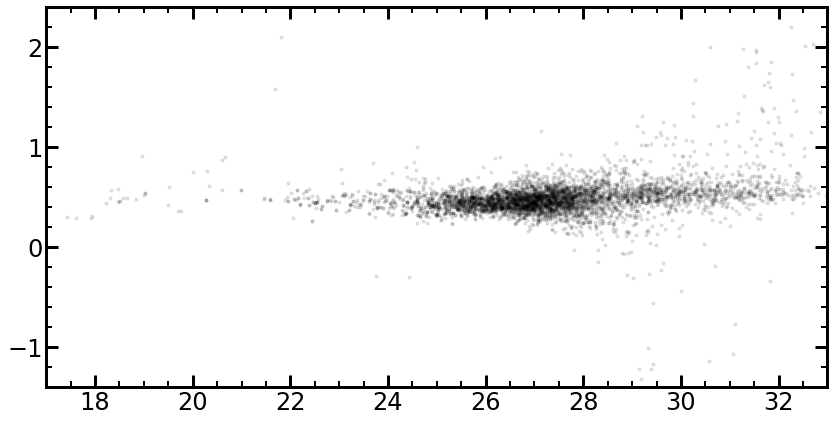

In [91]:
plt.figure()
plt.plot(mags_g_ap['apmag_3_0'][sel_cen][:,0], mags_g_ap['apmag_3_0'][sel_cen][:,0]-mags_g_ap['psfmag'][sel_cen][:,0], 'k.', alpha=0.1)
plt.ylim(-1.4,2.4)
plt.xlim(17,33)
plt.minorticks_on()

In [92]:
my_src14.getSchema()

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['I'](name="deblend_nChild", doc="Number of children this object has (defaults to 0)"), Key<I>(offset=32, nElements=1)),
    (Field['D'](name="base_SdssCentroid_x", doc="centroid from Sdss Centroid algorithm", units="pixel"), Key<D>(offset=40, nElements=1)),
    (Field['D'](name="base_SdssCentroid_y", doc="centroid from Sdss Centroid algorithm", units="pixel"), Key<D>(offset=48, nElements=1)),
    (Field['F'](name="base_SdssCentroid_xSigma", doc="1-sigma uncertainty on x position", units="pixel"), Key<F>(offset=56, nElements=1)),
    (Field['F'](name="base_SdssCentroid_ySigma", doc="1-sigma uncert

Next: concatenate the surrounding patches' catalogs, then move on to CMDs, density maps, etc.

In [93]:
%%time
# We must select object catalogs individually from the butler, then concatenate them.

#coadd_forced_src_array_g = []
#coadd_forced_src_array_r = []
#coadd_forced_src_array_i = []
coadd_forced_src_array = []

for ii in np.nonzero(selection_patch)[0]:
    tract, patch = df_tract_patch['tract'][ii], df_tract_patch['patch'][ii] 
    print('Tract, patch: ',tract, patch)
    dataid_g = {'filter':'HSC-G', 'tract':tract, 'patch':patch}
    dataid_r = {'filter':'HSC-R', 'tract':tract, 'patch':patch}
    dataid_i = {'filter':'HSC-I', 'tract':tract, 'patch':patch}
    coadd_forced_src_g = butler.get('deepCoadd_forced_src', dataId=dataid_g, flags=afwTable.SOURCE_IO_NO_FOOTPRINTS)
    coadd_ref_g = butler.get('deepCoadd_ref', dataId=dataid_g, flags=afwTable.SOURCE_IO_NO_FOOTPRINTS)
    coadd_calib_g = butler.get('deepCoadd_calexp_photoCalib', dataId=dataid_g)
    coadd_forced_src_r = butler.get('deepCoadd_forced_src', dataId=dataid_r, flags=afwTable.SOURCE_IO_NO_FOOTPRINTS)
    coadd_ref_r = butler.get('deepCoadd_ref', dataId=dataid_r, flags=afwTable.SOURCE_IO_NO_FOOTPRINTS)
    coadd_calib_r = butler.get('deepCoadd_calexp_photoCalib', dataId=dataid_r)
    coadd_forced_src_i = butler.get('deepCoadd_forced_src', dataId=dataid_i, flags=afwTable.SOURCE_IO_NO_FOOTPRINTS)
    coadd_ref_i = butler.get('deepCoadd_ref', dataId=dataid_i, flags=afwTable.SOURCE_IO_NO_FOOTPRINTS)
    coadd_calib_i = butler.get('deepCoadd_calexp_photoCalib', dataId=dataid_i)
    
    selection_catalog = coadd_ref_i['detect_isPrimary'] \
        & ~coadd_forced_src_i['base_SdssCentroid_flag'] \
        & ~coadd_forced_src_i['base_PixelFlags_flag_interpolated'] \
        & ~coadd_forced_src_i['base_PixelFlags_flag_saturated'] \
        & ~coadd_forced_src_i['base_PsfFlux_flag'] \
        & ~coadd_forced_src_i['modelfit_CModel_flag']
    
#    coadd_calib_g.setThrowOnNegativeFlux(False)
    psf_mag_g = coadd_calib_g.instFluxToMagnitude(coadd_forced_src_g, 'base_PsfFlux')
    cm_mag_g = coadd_calib_g.instFluxToMagnitude(coadd_forced_src_g, 'modelfit_CModel')
#    coadd_calib_r.setThrowOnNegativeFlux(False)
    psf_mag_r = coadd_calib_r.instFluxToMagnitude(coadd_forced_src_r, 'base_PsfFlux')
    cm_mag_r = coadd_calib_r.instFluxToMagnitude(coadd_forced_src_r, 'modelfit_CModel')
#    coadd_calib_i.setThrowOnNegativeFlux(False)
    psf_mag_i = coadd_calib_i.instFluxToMagnitude(coadd_forced_src_i, 'base_PsfFlux')
    cm_mag_i = coadd_calib_i.instFluxToMagnitude(coadd_forced_src_i, 'modelfit_CModel')
    
#    data = {'ra': np.degrees(coadd_forced_src['coord_ra'][selection_catalog]),
#            'dec': np.degrees(coadd_forced_src['coord_dec'][selection_catalog]),
    data = {'ra': np.degrees(coadd_forced_src_i['coord_ra'][selection_catalog]),
            'dec': np.degrees(coadd_forced_src_i['coord_dec'][selection_catalog]),
            'psf_mag_g': psf_mag_g[selection_catalog][:,0],
            'cm_mag_g': cm_mag_g[selection_catalog][:,0],
            'psf_mag_r': psf_mag_r[selection_catalog][:,0],
            'cm_mag_r': cm_mag_r[selection_catalog][:,0],
            'psf_mag_i': psf_mag_i[selection_catalog][:,0],
            'cm_mag_i': cm_mag_i[selection_catalog][:,0]}
#            'psf_mag': psf_mag[selection_catalog],
#            'cm_mag': cm_mag[selection_catalog]}
    coadd_forced_src_array.append(pd.DataFrame(data=data))

dir(coadd_forced_src_i)
df_hsc = pd.concat(coadd_forced_src_array)

Tract, patch:  17130 0,4
Tract, patch:  17130 1,5
Tract, patch:  17130 0,5
Tract, patch:  17130 2,4
Tract, patch:  17130 1,4
Tract, patch:  17130 2,5
Tract, patch:  17131 8,4
Tract, patch:  17131 8,5
CPU times: user 18.7 s, sys: 2.28 s, total: 21 s
Wall time: 23.7 s


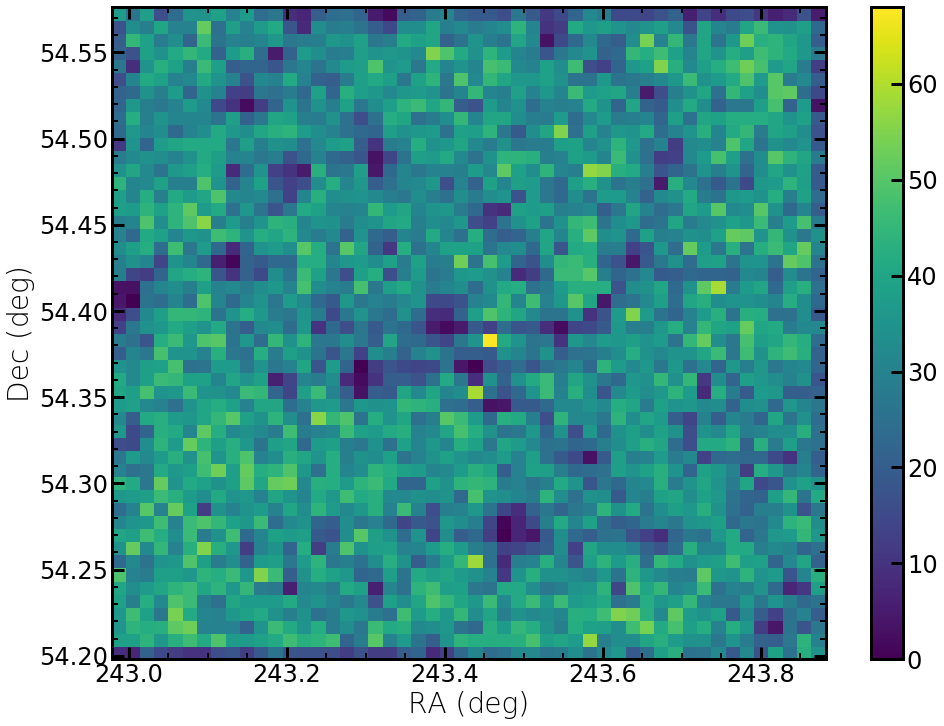

In [94]:
plt.rcParams.update({'figure.figsize' : (16, 12)})

plt.figure()
#plt.scatter(df_hsc['ra'], df_hsc['dec'], c='red', marker='.', s=10, alpha=0.1)
plt.hist2d(df_hsc['ra'], df_hsc['dec'], bins=50)
plt.colorbar()
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.minorticks_on()
plt.show()

In [95]:
#ok = df_hsc['psf_mag_g'].notna() & df_hsc['psf_mag_r'].notna() & df_hsc['psf_mag_i'].notna()
#df_hsc.dropna(thresh=1,inplace=True)
df_hsc.dropna(subset=['psf_mag_g', 'psf_mag_r', 'psf_mag_i'], inplace=True)

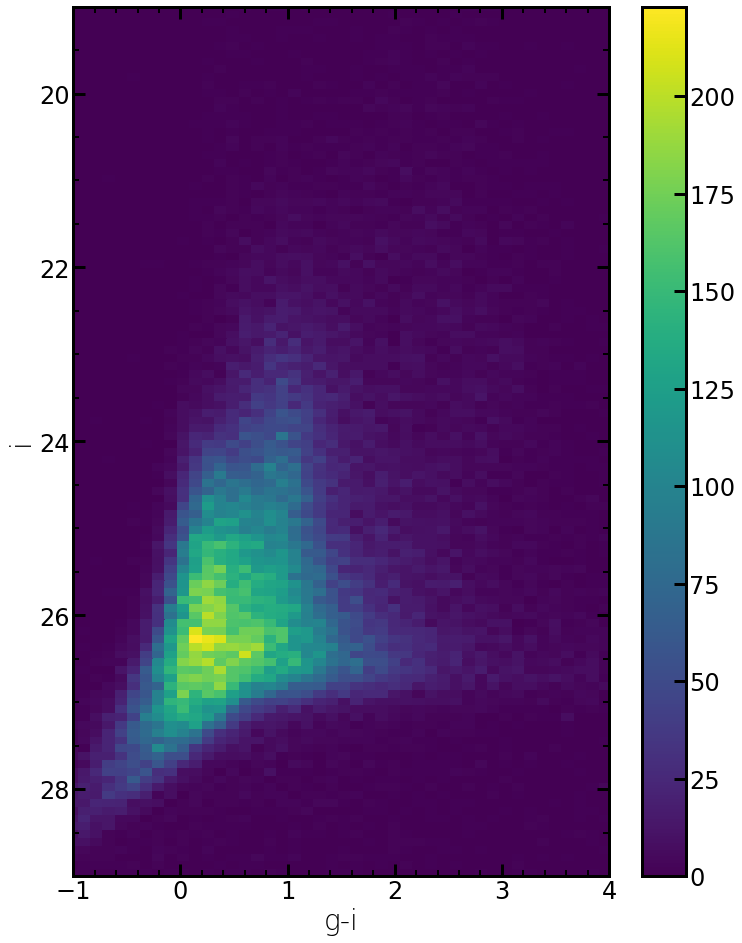

In [96]:
plt.rcParams.update({'figure.figsize' : (12, 16)})

plt.figure()

#plt.scatter(df_hsc['psf_mag_g']-df_hsc['psf_mag_i'], df_hsc['psf_mag_i'], c='red', marker='.', s=10, alpha=0.1)
plt.hist2d(df_hsc.psf_mag_g-df_hsc.psf_mag_i, df_hsc.psf_mag_i, bins=300)
#plt.hist2d(df_hsc[ok].psf_mag_g-df_hsc[ok].psf_mag_i, df_hsc[ok].psf_mag_i, bins=200)
plt.xlabel('g-i')
plt.ylabel('i')
plt.xlim(-1,4)
plt.ylim(29,19)
plt.colorbar()
plt.minorticks_on()
plt.show()

Text(0, 0.5, '$i_{\\rm PSF} - i_{\\rm cmodel}$')

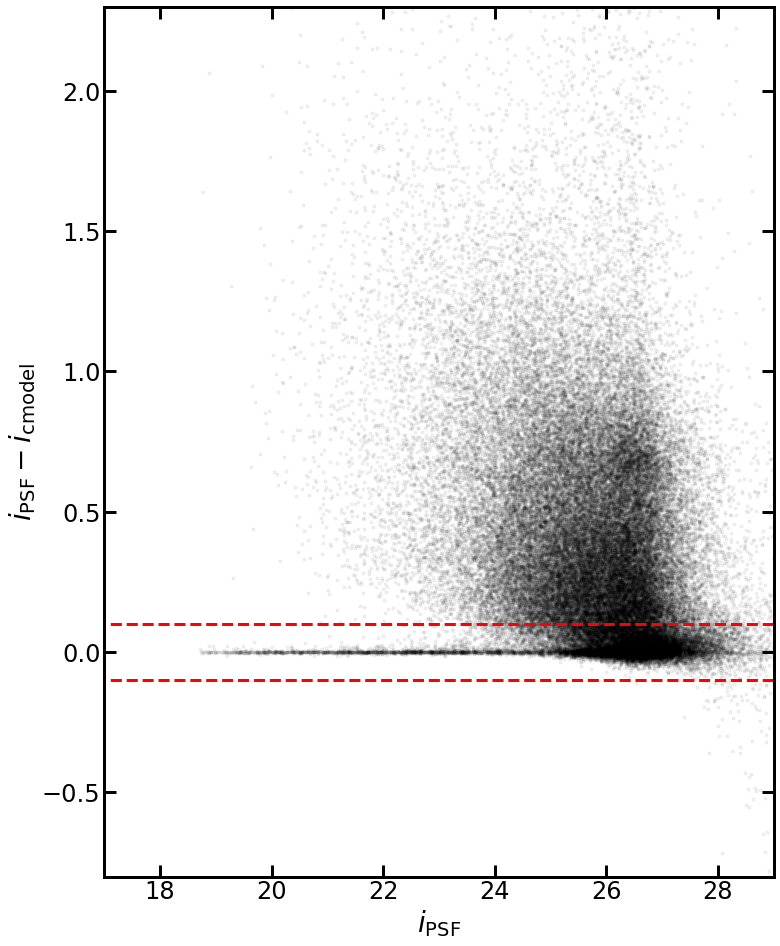

In [97]:
plt.figure()
plt.plot(df_hsc.psf_mag_i,df_hsc.psf_mag_i-df_hsc.cm_mag_i,'k.',alpha=0.05)
stargx_thresh = 0.1
plt.plot([0,30],[stargx_thresh,stargx_thresh],color='red',alpha=1.0,linestyle='--')
plt.plot([0,30],[-1.0*stargx_thresh,-1.0*stargx_thresh],color='red',alpha=1.0,linestyle='--')
plt.xlim(17,29)
plt.ylim(-0.8,2.3)
plt.xlabel(r'$i_{\rm PSF}$')
plt.ylabel(r'$i_{\rm PSF} - i_{\rm cmodel}$')

In [98]:
# Create "SkyCoord" objects for the central coordinate of KKR25 (or CetusIII, VirgoI?), and the patch centers of HSC:
kkr25_cen = SkyCoord(243.448333*u.degree, 54.37111*u.degree, frame='icrs')
#virgoI_cen = SkyCoord(180.04*u.degree, 0.68*u.degree, frame='icrs') # VirgoI
#kkr25_cen = virgoI_cen
hsc_coord = SkyCoord(df_hsc['ra'].values*u.degree, df_hsc['dec'].values*u.degree, frame='icrs')

# Calculate the separation (in degrees) of each HSC patch from KKR25:
sep_kkr25 = hsc_coord.separation(kkr25_cen)

# difference in mags (PSF - cmodel)
magdiff_i = df_hsc.psf_mag_i-df_hsc.cm_mag_i
starsel_i = (np.abs(magdiff_i) < stargx_thresh) & (df_hsc.psf_mag_g < 28) & (df_hsc.psf_mag_r < 28) & (df_hsc.psf_mag_i < 28)
rgbstarsel_i = (np.abs(magdiff_i) < stargx_thresh) & (df_hsc.psf_mag_g < 28) & (df_hsc.psf_mag_r < 28) & (df_hsc.psf_mag_i < 28) &\
               (df_hsc.psf_mag_g-df_hsc.psf_mag_i < 1.5) & (df_hsc.psf_mag_g-df_hsc.psf_mag_i > 0.5)             

# Pick patches within 'size_select' deg of KKR25:
size_select_kkr25 = 2.0/60.0 # in degrees
star_selection_kkr25 = (sep_kkr25.degree < size_select_kkr25) & starsel_i
notstar_selection_kkr25 = (sep_kkr25.degree < size_select_kkr25) & ~starsel_i
#print('Number of patches selected: ',np.sum(selection_patch))

In [99]:
# ! git clone https://github.com/asteca/ezpadova-2.git

In [100]:
## ! cp ezpadova-2/in_params_default.dat in_params.dat
#! python ezpadova-2/CMD.py

In [101]:
! ls isochrones/parsec12_panstarrs1

0_000100.dat  0_000500.dat  0_001520.dat


In [102]:
from astropy.io import ascii

iso = ascii.read('isochrones/parsec12_panstarrs1/0_000500.dat',header_start = 13)

dist = 1.7e6 # 1.91e6 # in pc
ebv = 0.008 # (E(B-V) = 0.008 according to Makarov+2012) -- look this up using the central coord?
dmod = 5.0*np.log10(dist) - 5.0 

# Raw PS1-band isochrone magnitudes
g_iso_ps1 = iso['gP1']
r_iso_ps1 = iso['rP1']
i_iso_ps1 = iso['iP1']
z_iso_ps1 = iso['zP1']

# Calculate colors needed to transform to HSC system
gr_iso_ps1 = g_iso_ps1 - r_iso_ps1
ri_iso_ps1 = r_iso_ps1 - i_iso_ps1
iz_iso_ps1 = i_iso_ps1 - z_iso_ps1

# PS1/HSC transformations from https://hsc-release.mtk.nao.ac.jp/doc/index.php/data/#color-terms
# Resulting mags are in the HSC filter system:
g_iso_hsc = g_iso_ps1 + 0.00730066 + 0.06508481*gr_iso_ps1 - 0.01510570*(gr_iso_ps1**2)
r_iso_hsc = r_iso_ps1 + 0.00279757 + 0.02093734*ri_iso_ps1 - 0.01877566*(ri_iso_ps1**2)
i_iso_hsc = i_iso_ps1 + 0.00166891 - 0.13944659*iz_iso_ps1 - 0.03034094*(iz_iso_ps1**2)

# Extinction coefficients from Schlafly+2011:
A_g = 3.172 * ebv
A_r = 2.271 * ebv
A_i = 1.682 * ebv

g_iso = g_iso_hsc + dmod + A_g
r_iso = r_iso_hsc + dmod + A_r
i_iso = i_iso_hsc + dmod + A_i 

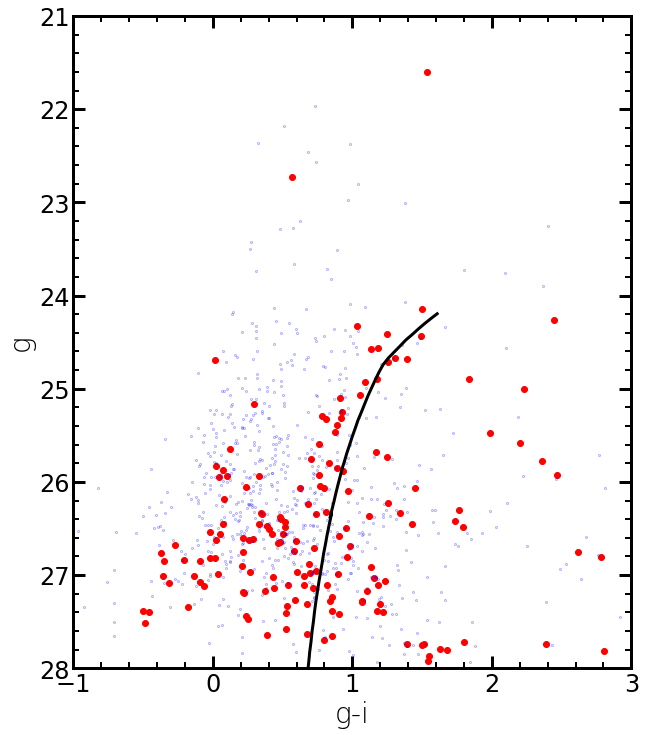

In [103]:
plt.rcParams.update({'figure.figsize' : (10, 12)})

plt.figure()

okstage = (iso['stage'] <= 3)

plt.plot(df_hsc[star_selection_kkr25].psf_mag_g-df_hsc[star_selection_kkr25].psf_mag_i, df_hsc[star_selection_kkr25].psf_mag_g, 'ro', ms=6)
plt.plot(df_hsc[notstar_selection_kkr25].psf_mag_g-df_hsc[notstar_selection_kkr25].psf_mag_i, df_hsc[notstar_selection_kkr25].psf_mag_g, 'bo', fillstyle='none', ms=2, alpha=0.3)
#plt.scatter(df_hsc[selection_kkr25].psf_mag_g-df_hsc[selection_kkr25].psf_mag_i, df_hsc[selection_kkr25].psf_mag_g,\
#            c=df_hsc[selection_kkr25].psf_mag_i-df_hsc[selection_kkr25].cm_mag_i, cmap='Spectral_r')
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.xlim(-1,3)
plt.ylim(28,21)
#plt.colorbar()
plt.minorticks_on()
plt.show()

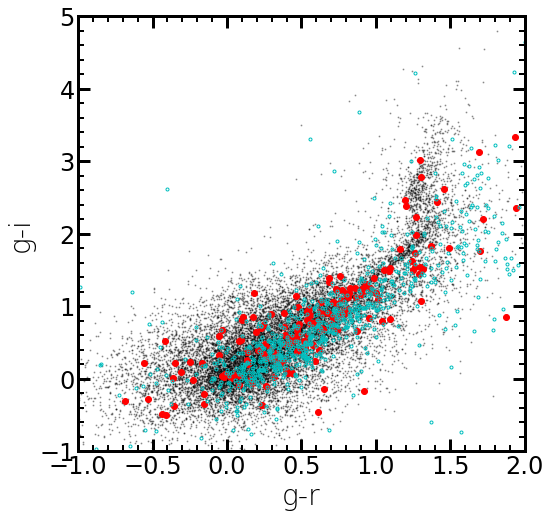

In [104]:
plt.rcParams.update({'figure.figsize' : (8, 8)})

plt.figure()

plt.plot(df_hsc[starsel_i].psf_mag_g-df_hsc[starsel_i].psf_mag_r, df_hsc[starsel_i].psf_mag_g-df_hsc[starsel_i].psf_mag_i, 'k.', ms=2, alpha=0.3)
#plt.plot(df_hsc[~starsel_i].psf_mag_g-df_hsc[~starsel_i].psf_mag_r, df_hsc[~starsel_i].psf_mag_g-df_hsc[~starsel_i].psf_mag_i, 'c.', ms=2, alpha=0.3)
plt.plot(df_hsc[star_selection_kkr25].psf_mag_g-df_hsc[star_selection_kkr25].psf_mag_r, df_hsc[star_selection_kkr25].psf_mag_g-df_hsc[star_selection_kkr25].psf_mag_i, 'ro', ms=6)
plt.plot(df_hsc[notstar_selection_kkr25].psf_mag_g-df_hsc[notstar_selection_kkr25].psf_mag_r, df_hsc[notstar_selection_kkr25].psf_mag_g-df_hsc[notstar_selection_kkr25].psf_mag_i, 'co', fillstyle='none', ms=3)
plt.xlabel('g-r')
plt.ylabel('g-i')
plt.xlim(-1,2)
plt.ylim(-1,5)
#plt.colorbar()
plt.minorticks_on()
plt.show()

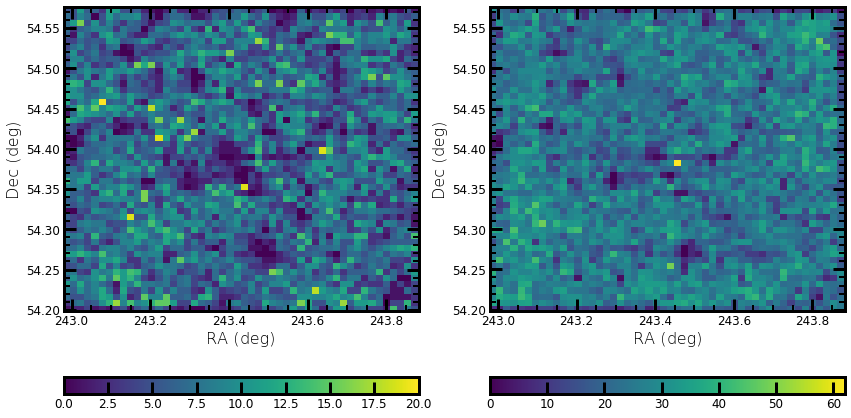

In [105]:
plt.rcParams.update({'figure.figsize' : (14, 8)})
plt.rcParams.update({'axes.labelsize': 16})
plt.rcParams.update({'font.size': 12})

plt.subplot(121)
#plt.scatter(df_hsc['ra'], df_hsc['dec'], c='red', marker='.', s=10, alpha=0.1)
#plt.hexbin(df_hsc[starsel_i]['ra'], df_hsc[starsel_i]['dec'], gridsize=50)
plt.hist2d(df_hsc[starsel_i]['ra'], df_hsc[starsel_i]['dec'], bins=50)
plt.colorbar(orientation="horizontal")
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.minorticks_on()
plt.subplot(122)
#plt.hexbin(df_hsc[~starsel_i]['ra'], df_hsc[~starsel_i]['dec'], gridsize=50)
plt.hist2d(df_hsc[~starsel_i]['ra'], df_hsc[~starsel_i]['dec'], bins=50)
plt.colorbar(orientation="horizontal")
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.minorticks_on()
plt.show()

## Try subtracting stars off the image(s)
(borrowing from J. Bosch's `intro-with-globular` notebook.

In [106]:
from lsst.afw.image import Exposure, Image, PARENT
from tqdm import tqdm_notebook

In [107]:
def subtractStars(data, cat, fluxes=None):
    """Subtract point sources from an image.
    
    Parameters
    ----------
    data : `lsst.afw.image.Exposure`
        Image from which point sources will be subtracted (not modified).
    cat : `lsst.afw.table.SourceCatalog`
        Catalog providing centroids and possibly fluxes.
    fluxes : `numpy.ndarray`, optional
        If not None, an array of the same length as ``cat`` containing fluxes
        to use.  If None, ``cat.getPsfFlux()` will be used instead.
        
    Returns
    -------
    model : `lsst.afw.image.Exposure`
        Image containing just the point source models.
    residuals : `lsst.afw.image.Exposure`
        ``data`` with ``model`` subtracted.
    """
    # Make sure no one calls this still-blended sources in the catalog.
    assert (cat["deblend_nChild"] == 0).all()
    # Get the PSF model from the given Exposure object.  The returned object
    # can be evaluated anywhere in the image to obtain an image of the PSF at
    # that point.
    psf = data.getPsf()
    # Make a new blank Exposure object with the same dimensions and pixel type.
    model = Exposure(data.getBBox(), dtype=np.float32)
    # Copy the WCS and PSF over from the original Exposure.
    model.setWcs(data.getWcs())
    model.setPsf(psf)
    if fluxes is None:
#        fluxes = cat.getPsfInstFlux()
#       Use the modified background to calculate stars' flux:
        fluxes = cat['base_PsfFlux_instFlux']-(cat['base_PsfFlux_area']*cat['base_LocalBackground_instFlux'])
    for flux, record in zip(fluxes, tqdm_notebook(cat)):
        # Check whether this source is in the image:
        if data.getBBox().contains(geom.Point2I(record.getCentroid())):
            # Obtain a PSF model image at the position of this source
            psfImage = psf.computeImage(record.getCentroid())
            # Make sure the PSF model image fits within the larger image; if it doesn't, clip it so it does.
            psfBBox = psfImage.getBBox()
            if not data.getBBox().contains(psfBBox):
                psfBBox.clip(data.getBBox())  # shrink the bounding box to the intersection
                psfImage = psfImage[psfBBox, PARENT]   # obtain a subimage
            # Make a subimage view of `model`, and subtract the PSF image, scaled by the flux.
            # PARENT here sets the coordinate system to be the one shared by all patches in
            # the tract rather than the one in which this patches' origin is (0, 0).
            # PARENT is the coordinate system used by the PSF, and it will soon be the default
            # here too (but isn't yet, so we need to make that explicit).
            model.image[psfBBox, PARENT].scaledPlus(flux, psfImage.convertF())
    # Now that we've made a model image, make a copy of the data and subtract the model from it.
    residuals = data.clone()
    residuals.image -= model.image
    return model, residuals

Before we can actually subtract the stars, we should remove the not-deblended sources; this function and the next one we write will assume they've been removed.

We can do that with NumPy-style boolean indexing, with one catch:

In [108]:
g_calexp = butler.get("deepCoadd_calexp", immediate=True, dataId=dataref14, filter='HSC-G')
g_calexp_calib = butler.get("deepCoadd_calexp_photoCalib", immediate=True, dataId=dataref14, filter='HSC-G')
i_calexp = butler.get("deepCoadd_calexp", immediate=True, dataId=dataref14, filter='HSC-I')
i_calexp_calib = butler.get("deepCoadd_calexp_photoCalib", immediate=True, dataId=dataref14, filter='HSC-I')

In [109]:
#g_calexp_calib.setThrowOnNegativeFlux(False)
gmags = g_calexp_calib.instFluxToMagnitude(cat_g, 'base_PsfFlux')
#i_calexp_calib.setThrowOnNegativeFlux(False)
imags = i_calexp_calib.instFluxToMagnitude(cat_i, 'base_PsfFlux')
okgmags = (gmags[:,0] < 28.5) & (gmags[:,0] > 18)
okimags = (imags[:,0] < 27.0) & (imags[:,0] > 18)

In [110]:
# deblended = catalog[catalog["deblend_nChild"] == 0].copy(deep=True)
deblended_g = cat_g[is_primary & deblended & okgmags & okimags].copy(deep=True)
deblended_i = cat_g[is_primary & deblended & okgmags & okimags].copy(deep=True)
#deblended_g = cat_g[is_primary & deblended & ptsource & okgmags & okimags].copy(deep=True)
#deblended_i = cat_g[is_primary & deblended & ptsource & okgmags & okimags].copy(deep=True)

Column arrays of `SourceCatalogs` can only be accessed when the catalog is stored in a single contiguous block of memory.  But unlike Numpy arrays, using boolean indexing on a catalog doesn't automatically make a copy to ensure memory is contiguous.  Instead it creates a view to the selected rows.  That can be useful or more efficient in some cases, but it also prevents us from accessing columns.  To fix that, we immediately make a deep copy of the catalog, which copies it into a new block of contiguous memory.

We can now run our `subtractStars` function.  Note the nice `tqdm` progress bar in action!

In [111]:
#model, residuals = subtractStars(coadds['r'], deblended)
#model, residuals = subtractStars(imgCutout, deblended_g)
# Note: had to re-read the original image because the mosaicked image doesn't contain the PSF.
model, residuals = subtractStars(g_calexp, deblended_g)
#model, residuals = subtractStars(gimgCutout_sub, deblended_g)

/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


(18600, 20100)

<Figure size 1008x576 with 0 Axes>

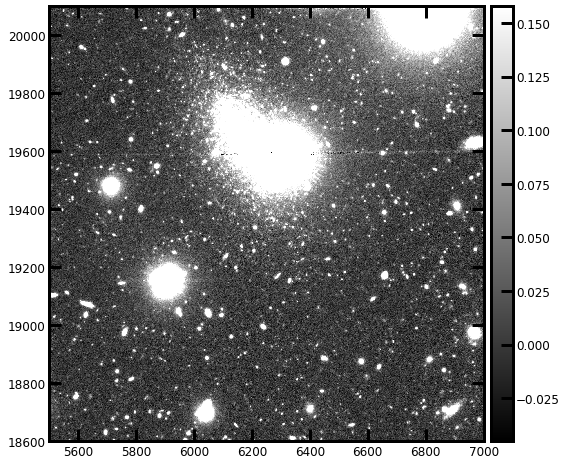

In [112]:
# Use lsst.afw.display with the matplotlib backend
plt.figure()
afw_display = afwDisplay.Display()
##afw_display.scale('asinh', 'zscale')
afw_display.scale('linear', 'zscale')
afw_display.mtv(g_calexp.image)
#afw_display.mtv(model)
#plt.xticks([])
#plt.yticks([])
plt.xlim(5500,7000)
plt.ylim(18600,20100)
#plt.savefig('orig_img_gband.png')

(18600, 20100)

<Figure size 1008x576 with 0 Axes>

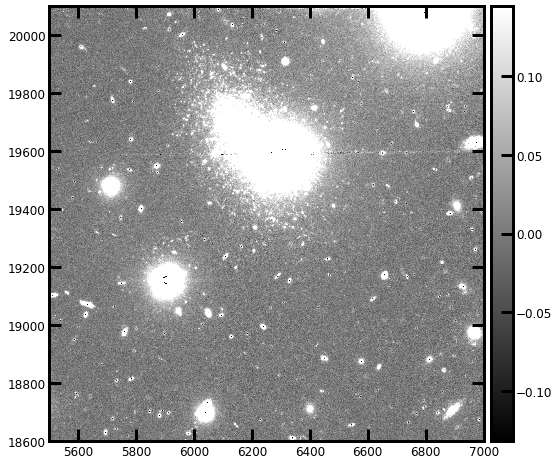

In [113]:
# Use lsst.afw.display with the matplotlib backend
plt.figure()
afw_display = afwDisplay.Display()
##afw_display.scale('asinh', 'zscale')
afw_display.scale('linear', 'zscale')
afw_display.mtv(residuals.image)
afw_display.setMaskTransparency(20)
afw_display.setMaskTransparency(10, 'DETECTED')
#plt.xticks([])
#plt.yticks([])
plt.xlim(5500,7000)
plt.ylim(18600,20100)
#plt.savefig('resid_img_gband.png')

<a class=“anchor” id=“kernel”></a>
# The Dwarf Filter (borrowed from Datalab DwarfGalaxiesInSmash_20180530.ipynb)
Here we define the dwarf filter as a differential convolution of a two-dimensional image using two Gaussian kernels; this has the effect of convolution with a Mexican hat filter.  The default kernel shapes look for objects on the scale of a few arcmin.  The output includes a clipped array of the convolved spatial distribution, which we will use for peak detection.

In [114]:
def dwarf_filter (ra,dec,fwhm_small=2.0,fwhm_big=20):

    """Differential convolution with 2D Gaussian kernels.
    
       Based on Koposov et al. (2008).
       Code by Ken Mighell and Mike Fitzpatrick.
       Minor edits by RN.
       
       Parameters
       ----------
       ra, dec : float or array
           RA & Dec in degrees.
    
       fwhm_small, fwhm_big : float
           Full-width half maximum sizes of the small and big Gaussian kernels
           to use in convolution, in arcminutes.
    """
    
    x, y = ra, dec

    print("Computing differential convolution .... ",)

    # Information about declination (y) [degrees]
    ymean = (y.min() + y.max()) / 2.0
    ydiff_arcmin = (y.max() - y.min()) * 60.0 # convert from degrees to arcmin

    # Information about right ascension (x) [degrees in time]:
    xdiff = x.max() - x.min() # angular separation [degrees (time)] 
    xmean = (x.min() + x.max()) / 2.0

    # convert from degrees in time to separation in angular degrees:
    xdiff_angular = (x.max() - x.min()) * np.cos(ymean*(np.pi/180.0))

    # convert from degress to arcmin
    xdiff_angular_arcmin = xdiff_angular * 60.0 

    # Get the number of one-arcmin pixels in the X and Y directions:
    nx = np.rint(xdiff_angular_arcmin).astype('int')
    ny = np.rint(ydiff_arcmin).astype('int')

    # Create a two-dimensional histogram of the raw counts:
    Counts, xedges, yedges  = np.histogram2d (x, y, (nx,ny) )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    raw_hist = np.rot90(Counts).copy() # hack around Pythonic weirdness

    # Make the small and big Gaussian kernels with a standard deviation
    # of the given FWHM in arcmin^2 pixels.
    kernel_small = convolution.Gaussian2DKernel(fwhm_small/2.35,factor=1)
    kernel_big = convolution.Gaussian2DKernel(fwhm_big/2.35,factor=1)

    # Compute the differential convolution kernels.
    conv_big = convolution.convolve(raw_hist, kernel_big)
    conv_small = convolution.convolve(raw_hist, kernel_small)
    conv_delta = conv_small - conv_big
    delta = conv_delta.copy()

    # Compute statistics and the floor
    mean = np.mean(delta, dtype='float64')
    sigma = np.std(delta, dtype='float64')
    sigmaRaw = np.std(raw_hist,dtype='float64')
    median = np.median(delta) # not used
    floor = mean

    print('dwarf_filter: mean = {:g}  sigma = {:g} sigmaRaw = {:g}'.format(mean, sigma, sigmaRaw))

    clipped = delta.copy()
    clipped[delta < floor] = floor

    # Return the computed fields.
    return raw_hist, extent, delta, clipped, sigma

In [115]:
%%time
from astropy import convolution
small_k, big_k = 1.0, 10.   # kernel sizes in arcmin
raw, extent, delta, clipped, dsigma = dwarf_filter(df_hsc[starsel_i]['ra'], df_hsc[starsel_i]['dec'], fwhm_small=small_k, fwhm_big=big_k)

Computing differential convolution .... 
dwarf_filter: mean = 5.08827  sigma = 7.44346 sigmaRaw = 8.00623
CPU times: user 143 ms, sys: 88.3 ms, total: 232 ms
Wall time: 462 ms


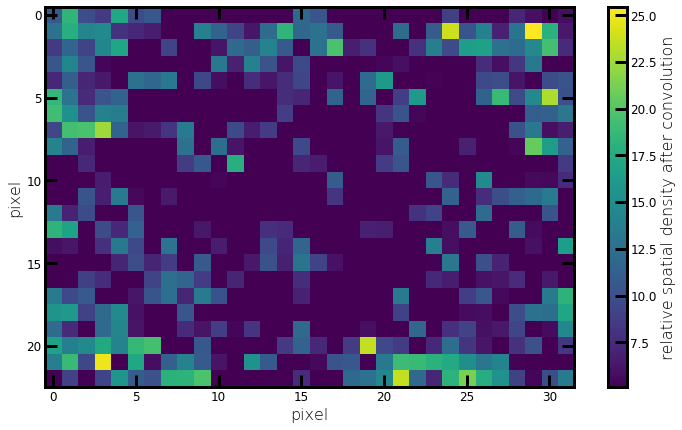

In [116]:
plt.rcParams.update({'figure.figsize' : (12, 7)})
#plt.subplots()
plt.figure()
plt.imshow(clipped)
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.colorbar(label='relative spatial density after convolution');

Next steps:

- "Proper" star/galaxy separation
- Fix data flags selection
- Adapt Datalab convolution kernel, overdensity selection technique
- Density changes with diff star/gx choices
- Subselections based on CMD/CCD, and possibly isochrone filtering

## Section Title

Explain what we are going to do in this section.

In [117]:
# If a particular line of python needs explaining, do it!
print("Hello World")

Hello World


## Summary

Remind the user what they have done, and what they should now be able to do.

You could also point them to a related tutorial or reference source, to help them go further.